In [1364]:
import pickle
from string import punctuation

import pandas as pd
from sklearn.model_selection import train_test_split

In [1365]:
import numpy as np
import json
import dask.bag as db

In [1366]:
# Load the data
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import dask.bag as db
import json

docs = db.read_text('../Data/arxiv-metadata-oai-snapshot.json').map(json.loads)

In [1593]:
# Trimming the data
get_latest_version = lambda x: x['versions'][-1]['created']


# get only necessary fields of the metadata file
trim = lambda x: {'id': x['id'],
                  'versions': x['versions'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],}

# filter for papers published before 2022
columns = ['id','category','abstract','versions']
docs_df = (docs.filter(lambda x: (int(get_latest_version(x).split(' ')[3]) >2004 and int(get_latest_version(x).split(' ')[3])<2022))
           .map(trim).
           compute())

# convert to pandas
docs_df = pd.DataFrame(docs_df)

In [1594]:
#save trimmed dataset for later use so we can skip the dataset trimming later:
docs_df.to_csv("../Data/trimmed_arxiv_docs4.csv", index=False)

In [1595]:
# Read docs from the file
df = pd.read_csv('../Data/trimmed_arxiv_docs4.csv')

In [1596]:
categories = list(df['category'].unique())

In [1597]:
# Split categories
def splitCategory(cat):
    tmp = cat.replace('[','').replace(']','')
    c = tmp.split(', ')
    c = [w.replace("'","") for w in c]
    return c

In [1598]:
# Find main category
def findMainCat(categories):
    new_cat = list(dict.fromkeys([cat.split(".")[0] for cat in categories]))
    return new_cat

In [1599]:
# Getting rid of duplicates
df.drop_duplicates(['abstract',], inplace=True)
df['abstract'].describe(include='all')

count                                               1684767
unique                                              1684767
top         A fully differential calculation in perturba...
freq                                                      1
Name: abstract, dtype: object

NLP Processing

In [1600]:
# Add the categories
df['list_categories'] = df.category.apply(splitCategory)
df['main_categories'] = df.list_categories.apply(findMainCat)

In [1601]:
# Create CS and Random dataframes
bool_series = ["cs" == cat[0] for cat in df.main_categories]
df_cs = df[bool_series]

In [1602]:
# Non-CS df
bool_series = [cat[0] != "cs" for cat in df.main_categories]
df_random = df[bool_series]

In [1622]:
def get_year(version):
    ver = version.split('}')
    return int(ver[-2].split(': ')[2].split(' ')[3])

In [1604]:
import datetime
def get_month(version):
    month_name = version.split(': ')[2].split(' ')[2]
    datetime_object = datetime.datetime.strptime(month_name, "%b")
    month_number = datetime_object.month
    return month_number

In [1605]:
def get_quarter(version):
    year = get_year(version)
    month = get_month(version)
    date = int(year)*4+int(month/3)
    return date

In [1623]:
df_cs['year'] = df_cs.versions.apply(get_year)
df_random['year'] = df_random.versions.apply(get_year)
df_cs['quarter'] = df_cs.versions.apply(get_quarter)
df_random['quarter'] = df_random.versions.apply(get_quarter)

/var/folders/9k/9qw6yrzx6493tcr085_zrwj40000gn/T/ipykernel_1231/3872019404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cs['year'] = df_cs.versions.apply(get_year)
/var/folders/9k/9qw6yrzx6493tcr085_zrwj40000gn/T/ipykernel_1231/3872019404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_random['year'] = df_random.versions.apply(get_year)
/var/folders/9k/9qw6yrzx6493tcr085_zrwj40000gn/T/ipykernel_1231/3872019404.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [1625]:
# Exclude 2022
bool_series = [year<2022 for year in df_cs.year]
df_cs = df_cs[bool_series]

In [1626]:
# Exclude 2022
bool_series = [year<2022 for year in df_random.year]
df_random = df_random[bool_series]

Reducing the dataset

In [1628]:
def findSubCat(cat):
    try:
        return cat[0].split(".")[1]
    except:
        print(cat)
        return 'none'

In [1629]:
df_cs['sub_category'] = df_cs.list_categories.apply(findSubCat)
#df_random['sub_category'] = df_random.list_categories.apply(findSubCat)

In [1630]:
from collections import Counter
csub = Counter(list(df_cs['sub_category']))

In [1631]:
csub = csub.most_common()

In [1632]:
#Number of paper in cs
print(len(df_random.index))
print(len(df_cs.index))

1367765
317002


In [1633]:
from collections import OrderedDict
csub = OrderedDict(csub)

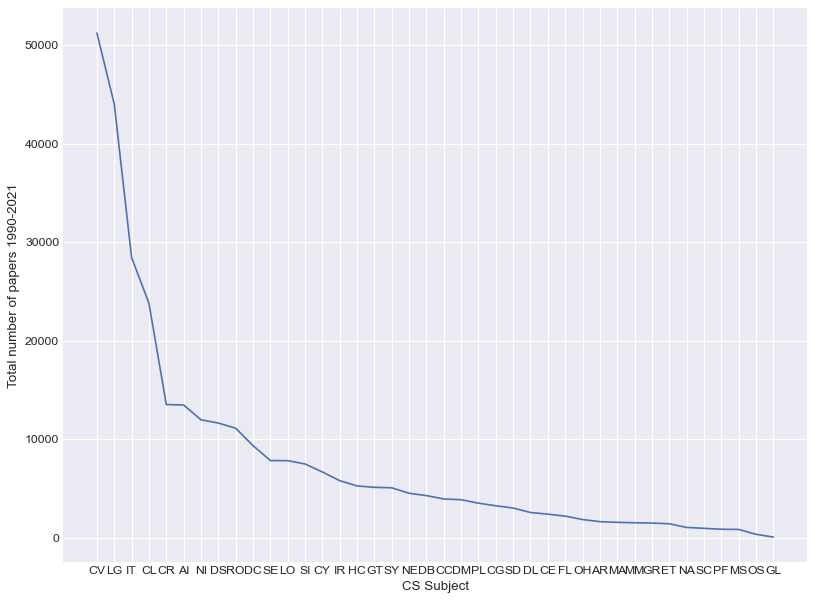

<Figure size 1300x1300 with 0 Axes>

In [1634]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(12, 9), dpi=80)
x_plt = list(csub.keys())
y_plt = list(csub.values())
plt.plot(x_plt, y_plt)
plt.xlabel("CS Subject")
plt.ylabel("Total number of papers 1990-2021")
plt.show()
plt.savefig('../Graphs/Final/subjectDistributionFinal2.png')

In [1635]:
subcategories = list(set(list(df_cs['sub_category'])))

In [1636]:
df_cs_reduced = pd.DataFrame(columns=list(df_cs.columns))
for subcat in subcategories:
    if(len(df_cs[df_cs['sub_category'] == subcat].index)>=2000):
        df_cs_reduced = df_cs_reduced.append(df_cs[df_cs['sub_category'] == subcat].sample(2000))
    else:
        df_cs_reduced = df_cs_reduced.append(df_cs[df_cs['sub_category'] == subcat])

In [1637]:
df_cs_reduced = df_cs_reduced.drop(columns='versions')

In [1638]:
# Reduce the size of the data
df_random = df_random.sample(len(df_cs_reduced.index), random_state=42)

In [1639]:
df_cs_reduced.to_csv("../Data/df_cs_reduced.csv", index=False)
df_random.to_csv("../Data/df_random_reduced.csv", index=False)

In [1640]:
df_cs = df_cs_reduced

NLP Processing

In [1641]:
#Define stopwords (scientific stopwords)
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = STOP_WORDS

In [1642]:
#Define the cleaner - remove punctuation
def cleanPunct(text):
    return [w for w in text if w not in punctuation]

In [1643]:
# make everything lowercase
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def low(instance):
    tokens = word_tokenize(instance)
    return [w.lower() for w in tokens if w not in ["(", ")"]]
# Removing stopwords and punctuation
def clean(text):
    return [w for w in text if w not in punctuation and w not in stopwords and w.isalpha() and len(w)>1]
def low2(instance):
    tokens = word_tokenize(instance)
    return [w.lower() for w in tokens if w not in punctuation and w not in stopwords and w.isalpha() and len(w)>1]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/miamijovic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1644]:
# Create column with lowercase text
df_cs['cleaned'] = df_cs.abstract.apply(low2)
df_random['cleaned'] = df_random.abstract.apply(low2)

In [1645]:
# Make ngrams
from nltk.util import ngrams

def bigrams(arr):
    return list(ngrams(arr, 2))

def trigrams(arr):
    return list(ngrams(arr,3))

In [1646]:
# Creating ngrams
df_cs['bigrams'] = df_cs.cleaned.apply(bigrams)
df_random['bigrams'] = df_random.cleaned.apply(bigrams)
df_cs['trigrams'] = df_cs.cleaned.apply(trigrams)
df_random['trigrams'] = df_random.cleaned.apply(trigrams)

In [1647]:
def hyphenate(words, n):
    if(n==2):
        return [w[0]+'-'+w[1] for w in words]
    if(n==3):
        return [w[0]+'-'+w[1]+'-'+w[2] for w in words]

Language analysis

In [1648]:
# Create dict func
def createDict(data):
    vocab = {}
    for instance in data:
        d = Counter(instance)
        for w in d.keys():
            if w in vocab:
                vocab[w] += d[w]
            else:
                vocab[w] = d[w]
    return dict(sorted(vocab.items(), key=lambda item: item[1], reverse=True))

In [1649]:
from collections import Counter
uni_cs = createDict(df_cs['cleaned'])
bi_cs = createDict(df_cs['bigrams'])
tri_cs = createDict(df_cs['trigrams'])

uni_rand = createDict(df_random['cleaned'])
bi_rand = createDict(df_random['bigrams'])
tri_rand = createDict(df_random['trigrams'])

In [1650]:
# Trim ngrams 
def trim(d, num):
    return dict((k, v) for k, v in d.items() if v>=num)

In [1651]:
trim_value = 40
unigram_cs = trim(uni_cs, trim_value)
unigram_rand = trim(uni_rand, trim_value)
bigram_cs = trim(bi_cs, trim_value)
bigram_rand = trim(bi_rand, trim_value)
trigram_cs = trim(tri_cs, trim_value)
trigram_rand = trim(tri_rand, trim_value)

In [1652]:
# Filter out dataframe, leave only ngrams from the list + hyphenate
def filterOutUniCs(words):
    return [w for w in words if w in unigram_cs]
def filterOutBiCs(words):
    return [w[0]+'-'+w[1] for w in words if w in bigram_cs]
def filterOutTriCs(words):
    return [w[0]+'-'+w[1]+'-'+w[2] for w in words if w in trigram_cs]
def filterOutUniRand(words):
    return [w for w in words if w in unigram_rand]
def filterOutBiRand(words):
    return [w[0]+'-'+w[1] for w in words if w in bigram_rand]
def filterOutTriRand(words):
    return [w[0]+'-'+w[1]+'-'+w[2] for w in words if w in trigram_rand]

In [1653]:
df_cs.cleaned = df_cs.cleaned.apply(filterOutUniCs)
df_cs.bigrams = df_cs.bigrams.apply(filterOutBiCs)
df_cs.trigrams = df_cs.trigrams.apply(filterOutTriCs)

df_random.cleaned = df_random.cleaned.apply(filterOutUniRand)
df_random.bigrams = df_random.bigrams.apply(filterOutBiRand)
df_random.trigrams = df_random.trigrams.apply(filterOutTriRand)

Chi-Squared

In [1654]:
#CHI-Square stastic where:
# a - number of times t and c co-occur 11
# b - number of times t occurs w/o c 10
# c - number of times c occurs w/o t 01
# d - number of times neither c nor t occur 00
def chi_square(n,a,b,c,d):
    return n*((a*d-c*b)**2)/((a+c)*(b+d)*(a+b)*(c+d))

In [1655]:
def selectKbest(features, k):
    features = {a: v for a, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    features = {a: features[a] for a in list(features)[:k]}
    return features

In [1656]:
# a - number of times t and c co-occur 11 (term occurs in cs)
# b - number of times t occurs w/o c 10 (term occurs in random)
# c - number of times c occurs w/o t 01 (cs which dont contain term)
# d - number of times neither c nor t occur 00 (random which dont contain term)
def findChiValuesQuicker(cs_dict, random_dict, n):
    occurance_dict = {}
    chi_values = {}
    for instance in cs_dict['filteredAbstracts'].keys():
        terms = Counter(cs_dict['filteredAbstracts'][instance])
        for term in terms.keys():
            if(term in occurance_dict.keys()):
                if('a' in occurance_dict[term].keys()):
                    occurance_dict[term]['a'] += 1
                else:
                    occurance_dict[term]['a'] = 1
            else:
                occurance_dict[term] = {'a' : 1}
    for instance in random_dict['filteredAbstracts'].keys():
        terms = Counter(random_dict['filteredAbstracts'][instance])
        for term in terms.keys():
            if(term in occurance_dict.keys()):
                if('b' in occurance_dict[term].keys()):
                    occurance_dict[term]['b'] += 1
                else:
                    occurance_dict[term]['b'] = 1
            else:
                occurance_dict[term] = {'b' : 1}
    for term in occurance_dict.keys():
        if('a' in occurance_dict[term].keys()):
            occurance_dict[term]['c'] = int(n/2)-occurance_dict[term]['a']
        else:
            occurance_dict[term]['c'] = int(n/2)
            occurance_dict[term]['a'] = 0
        if('b' in occurance_dict[term].keys()):
            occurance_dict[term]['d'] = int(n/2)-occurance_dict[term]['b']
        else:
            occurance_dict[term]['d'] = int(n/2)
            occurance_dict[term]['b'] = 0
        chi_values[term] = chi_square(n, occurance_dict[term]['a'], occurance_dict[term]['b'], occurance_dict[term]['c'], occurance_dict[term]['d'])
    return chi_values

In [1657]:
# Filter
def filterAbstract(tokens, chi_best_bi, chi_best_tri):
    # Find trigrams
    i = 0
    new1 = []
    while(i<len(tokens)-2):
        trigram = tokens[i]+'-'+tokens[i+1]+'-'+tokens[i+2]
        if(trigram in chi_best_tri):
            new1.append(trigram)
            i += 3
        else:
            new1.append(tokens[i])
            i += 1
    
    #Find bigrams
    i = 0
    new2 = []
    while(i<len(new1)-1):
        bigram = new1[i]+'-'+new1[i+1]
        if(bigram in chi_best_bi):
            new2.append(bigram)
            i += 2
        else:
            new2.append(new1[i])
            i += 1


    return new2

In [1658]:
cs_dict = df_cs.to_dict()
random_dict = df_random.to_dict()

In [1659]:
cs_dict['filteredAbstracts'] = {}
for instance in cs_dict['cleaned'].keys(): 
    cs_dict['filteredAbstracts'][instance] = filterAbstract(cs_dict['cleaned'][instance], cs_dict['bigrams'][instance], cs_dict['trigrams'][instance])

In [1660]:
random_dict['filteredAbstracts'] = {}
for instance in random_dict['cleaned'].keys(): 
    random_dict['filteredAbstracts'][instance] = filterAbstract(random_dict['cleaned'][instance], random_dict['bigrams'][instance], random_dict['trigrams'][instance])

In [1661]:
chi_values_quicker = findChiValuesQuicker(cs_dict, random_dict, len(df_cs.index)*2)

In [1662]:
sorted_chi_values_quicker = {a: v for a, v in sorted(chi_values_quicker.items(), key=lambda item: item[1], reverse=True)}

In [1663]:
sorted_chi_values_quicker

{'users': 3559.6475516585833,
 'algorithms': 3069.7185759577815,
 'user': 2982.193290644728,
 'algorithm': 2937.907324953717,
 'network': 2647.7627293301357,
 'task': 2645.8285783578635,
 'mass': 2509.553615965529,
 'design': 2453.3086707812918,
 'tasks': 2354.443130356989,
 'performance': 2319.7210367412827,
 'observed': 2302.4497136462455,
 'learning': 2174.277794694166,
 'language': 2035.4715236729176,
 'quantum': 1939.9334388367429,
 'emission': 1936.9667133556923,
 'architecture': 1902.5487933816416,
 'in-paper-propose': 1809.931748843801,
 'spectra': 1792.9550869397037,
 'online': 1768.2687662544015,
 'stars': 1766.7551320377233,
 'information': 1719.023788864695,
 'magnetic': 1690.231558529365,
 'training': 1687.2553006372407,
 'spin': 1678.2454321672965,
 'dataset': 1668.262616478929,
 'particles': 1653.0908407671375,
 'communication': 1608.1512774463777,
 'existing': 1602.4228142008726,
 'software': 1600.9555753545394,
 'optical': 1590.2782595843582,
 'networks': 1557.74710280

In [1664]:
# Filter by chi value chiVal
def selectChiBest(features, chiVal):
    #features = {a: v for a, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    features2 = {a: features[a] for a in features if features[a]>chiVal}
    return features2

In [1665]:
chiVal = 90
chi_best = selectChiBest(sorted_chi_values_quicker, chiVal)
print(len(chi_best))

5207


In [1666]:
df_cs.columns

Index(['id', 'category', 'abstract', 'list_categories', 'main_categories',
       'year', 'quarter', 'sub_category', 'cleaned', 'bigrams', 'trigrams'],
      dtype='object')

In [1667]:
df_combined = df_cs[['abstract', 'list_categories', 'main_categories', 'year', 'quarter', 'sub_category']]

In [1668]:
df_combined

abstract  \
1352       This paper reports on work aimed at supporti...   
1837       The recently ratified IEEE 802.11e standard ...   
1841       Most of the deployed IEEE 802.11e Wireless L...   
2281       The configurations of single and double bond...   
6353       This paper details the use of the IT Infrast...   
...                                                    ...   
752273     This paper studies a data recovery problem i...   
696641     This paper studies recursive composite hypot...   
406786     Recommendation systems are information-filte...   
222059     A bio-inspired robust adaptive random search...   
1163608    The definition of the graph Fourier transfor...   

                      list_categories main_categories  year quarter  \
1352     [cs.OH, cs.DB, cs.DL, cs.HC]            [cs]  2007    8029   
1837                          [cs.OH]            [cs]  2007    8029   
1841                          [cs.OH]            [cs]  2007    8029   
2281                   [cs.OH, cs.DM]            [cs]  2007    8029   
6353                          [cs.OH]            [cs]  2007    8029   
...                               ...             ...   ...     ...   
752273               [cs.IT, math.IT]      [cs, math]  2017    8070   
696641      [cs.IT, math.IT, math.PR]      [cs, math]  2017    8068   
406786      [cs.IT, math.IT, math.OC]      [cs, math]  2013    8052   
222059               [cs.IT, math.IT]      [cs, math]  2011    8047   
1163608              [cs.IT, math.IT]      [cs, math]  2019    8078   

        sub_category  
1352              OH  
1837              OH  
1841              OH  
2281              OH  
6353              OH  
...              ...  
752273            IT  
696641            IT  
406786            IT  
222059            IT  
1163608           IT  

[69723 rows x 6 columns]

In [1669]:
def filterAbstract(cs_dict, chi_best):
    completeDict = dict(chi_best)
    for key in cs_dict['filteredAbstracts'].keys():
        for term in cs_dict['filteredAbstracts'][key]:
            if term not in chi_best:
                cs_dict['filteredAbstracts'][key].remove(term)
                if(term in completeDict.keys()):
                    del completeDict[term]
    return cs_dict, completeDict

In [1681]:
cs_dict_filtered, completeDict = filterAbstract(cs_dict, chi_best)

In [1682]:
for val in cs_dict_filtered['filteredAbstracts'].values():    
    for key in val:
        if(key not in chi_best):
            print(key)

In [1683]:
# How big is the corpus
corpus_len = 0
for key in cs_dict_filtered['filteredAbstracts']:
    for abstract in cs_dict_filtered['filteredAbstracts'][key]:
        corpus_len += len(abstract)
print(corpus_len)

21067403


In [ ]:
# Join in a form for glove training
abstr = [" ".join(abstract) for abstract in list(cs_dict_filtered['filteredAbstracts'].values())]
abstracts = "\n".join(abstr)

In [ ]:
import itertools
with open('../glove/new_abstracts.txt', 'w') as f:
    f.write(abstracts)

GloVe Embeddings

In [1684]:
import numpy as np
vectors_path = '../glove/vectors.txt' # Change this to the relative path on your machine

def load_glove_model(File):
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

vectors = load_glove_model(vectors_path)
print(vectors['paper'])

3816 words loaded!
[-4.55869e-01 -8.33530e-02  1.29114e-01 -5.74870e-02 -1.05309e-01
  1.32345e-01 -4.66981e-01  5.33786e-01  3.24302e-01  8.76160e-02
  2.93685e-01 -3.26061e-01  7.23513e-01 -1.50223e-01 -2.78074e-01
  4.70577e-01  6.43952e-01  5.31253e-01  4.45866e-01  2.40871e-01
 -4.11550e-01  4.45000e-04  5.05008e-01  7.14560e-01 -3.16821e-01
  1.70400e-03 -6.33837e-01 -9.34800e-03 -5.99528e-01 -7.98739e-01
  1.79493e-01 -2.45461e-01  9.18520e-02  6.76664e-01  3.82785e-01
  4.09859e-01  2.03831e-01  6.63369e-01 -7.23802e-01 -6.58551e-01
 -5.19683e-01  4.24412e-01 -8.01134e-01 -6.88995e-01  1.77876e-01
  2.76943e-01  7.58040e-02 -5.88360e-02  1.01228e-01  3.19571e-01]


In [1685]:
def createVectors(all_terms, vectors):
    termDict = {}
    for term in all_terms:
        try:
            termDict[term] = vectors[term]
        except:
            print(term)
    return termDict

In [1686]:
def vec2term(vector, vectors):
    for vec in vectors:
        if vec.value().all == vector:
            return vec.key()
    return "NO MATCH"

In [1687]:
termDict = createVectors(completeDict, vectors)

galaxies
galaxy
stellar
electrons
relativistic
plasma
spectroscopy
photon
ground-state
cosmological
telescope
luminosity
gravitational
black-hole
galactic
photons
dark-matter
vacuum
chiral
orbital
qcd
gev
redshift
dust
lhc
resonances
bright
magnetization
quark
graphene
amplitudes
excitations
neutrino
jet
star-formation
spectroscopic
fermions
ions
transverse
astrophysical
dirac
mev
black-holes
su
accretion
charged
magnetic-fields
cosmic
nuclei
ion
jets
superconductivity
photometry
ferromagnetic
neutrinos
metallic
suppressed
proton
halo
we-calculate
tev
phase-diagram
wavelengths
electric-field
cosmology
scalar-field
angular-momentum
supersymmetric
excited
inflation
exotic
perturbative
neutron
spins
atmosphere
planets
kpc
shock
cohomology
quarks
metallicity
hydrogen
fermion
hadronic
planet
phenomenological
ionization
higgs
observatory
antiferromagnetic
cross-section
agn
fermi
fluxes
general-relativity
condensate
superconductors
kev
au
density-functional-theory
hydrodynamic
doping
abundanc

In [ ]:
with open('../Data/termDict2.json', 'w') as outfile:
    json.dump(str(termDict), outfile)   

Clustering

In [1688]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn import metrics

In [3208]:
k = 300
kmeans = KMeans(n_clusters=k, random_state=42)
np_vectors= list(termDict.values())

In [3209]:
import math
for i in range(len(np_vectors)):
    if(np.isnan(np.sum(np_vectors[i]))):
        np_vectors[i] = [0]*50

In [3210]:
#PCA reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=20)

pca.fit(np_vectors)

PCA(n_components=20)

In [3211]:
def kMeansPredict(np_vector):
    return kmeans.fit_predict(np_vector)

y_pred= kMeansPredict(np_vectors)

In [3212]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(np_vectors)

/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


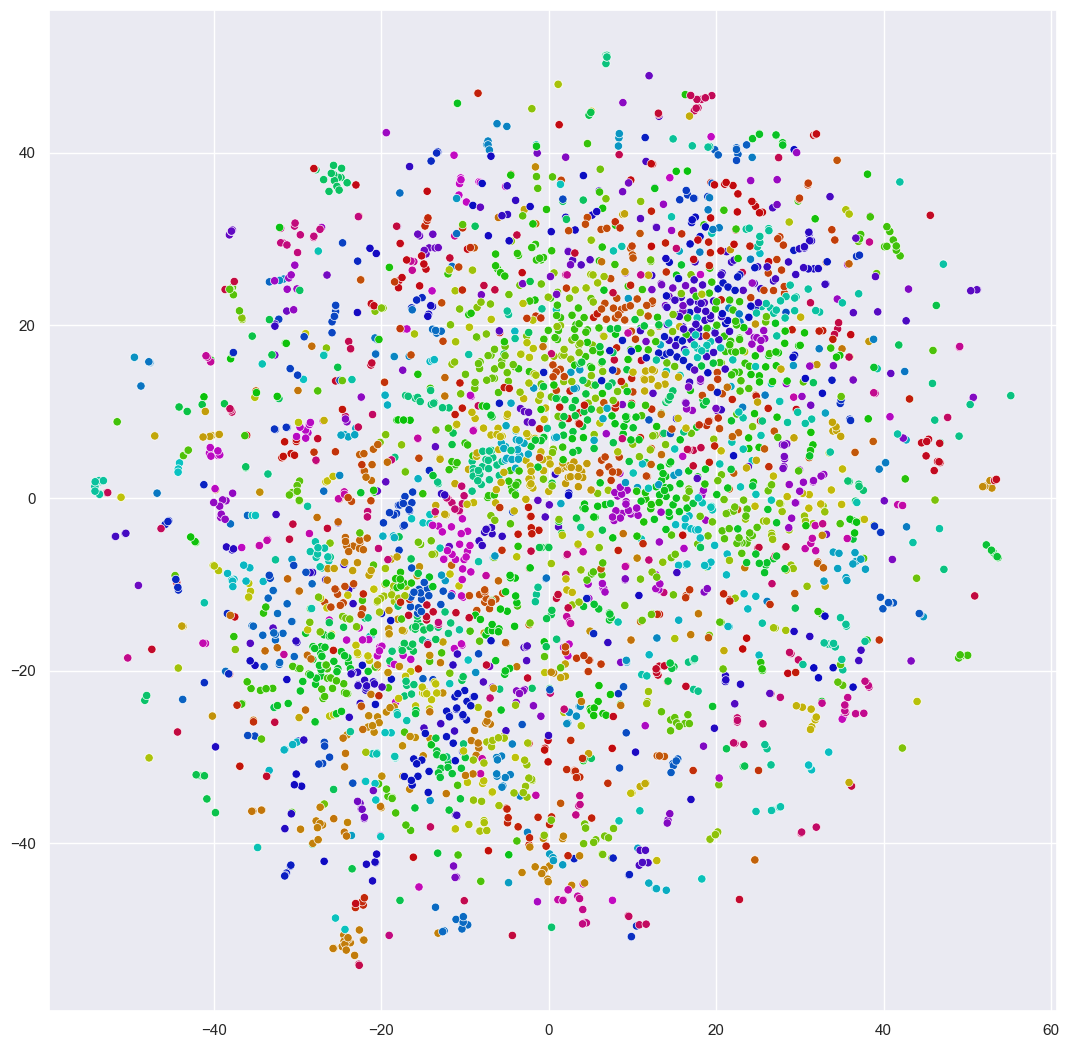

In [3213]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(13,13)})

palette = sns.hls_palette(k, l=.4, s=.9)

sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=y_pred, palette=palette, legend=False)
plt.savefig('../Graphs/scatterPlotTopics.png')

In [3214]:
zip_iterator = zip(termDict.keys(), y_pred)

value_clusters = dict(zip_iterator)

In [3215]:
clusters = {}
for term in value_clusters.items():
    clusters[term[1]] = []
for term in value_clusters.items():
    clusters[term[1]].append(term[0])

In [3216]:
for i in clusters.keys():
    print(i,clusters[i])

203 ['users', 'user']
48 ['algorithms', 'algorithm', 'complexity', 'strategies', 'found', 'instances', 'strategy', 'settings', 'variants', 'optimal', 'best', 'setting', 'selection', 'case', 'range', 'larger', 'good', 'schemes', 'leads', 'finally', 'additionally', 'furthermore', 'provided', 'conditions', 'moreover', 'depending']
199 ['network', 'networks', 'nodes', 'node', 'connectivity', 'links']
34 ['task', 'tasks', 'perform', 'performs', 'inference', 'expert', 'performing']
174 ['mass', 'temperature', 'temperatures', 'pressure', 'feedback', 'force', 'law', 'forces']
207 ['design', 'communication', 'need', 'needs', 'requirements', 'building', 'designing', 'capabilities', 'providing', 'computational', 'reliability', 'systems', 'capability', 'functionality', 'provide', 'process', 'required', 'system', 'key', 'therefore', 'hence', 'operational', 'integration', 'needed', 'necessary', 'essential', 'thus', 'crucial']
183 ['performance', 'improve', 'better', 'scalability', 'achieve', 'improv

In [3217]:
df_combined['filteredAbstracts'] = cs_dict_filtered['filteredAbstracts'].values()

In [3218]:
df_combined.to_csv('../Data/df_combined_new')

Number of hits per topic

In [3219]:
def topicHits(text, value_clusters):
    topics = {}
    wordDict = Counter(text)
    for word in wordDict.keys():
        if(word in value_clusters.keys()):
            topics[value_clusters[word]] = wordDict[word]
    return topics

In [3220]:
#Just return which topics were hit
def pureTopics(topics):
    return topics.keys()

In [3221]:
df_combined['topic_hits'] = df_combined.filteredAbstracts.apply(topicHits, value_clusters=value_clusters)
df_combined['topics'] = df_combined.topic_hits.apply(pureTopics)
df_combined

abstract  \
1352       This paper reports on work aimed at supporti...   
1837       The recently ratified IEEE 802.11e standard ...   
1841       Most of the deployed IEEE 802.11e Wireless L...   
2281       The configurations of single and double bond...   
6353       This paper details the use of the IT Infrast...   
...                                                    ...   
752273     This paper studies a data recovery problem i...   
696641     This paper studies recursive composite hypot...   
406786     Recommendation systems are information-filte...   
222059     A bio-inspired robust adaptive random search...   
1163608    The definition of the graph Fourier transfor...   

                      list_categories main_categories  year quarter subfield  \
1352     [cs.OH, cs.DB, cs.DL, cs.HC]            [cs]  2007    8029       OH   
1837                          [cs.OH]            [cs]  2007    8029       OH   
1841                          [cs.OH]            [cs]  2007    8029       OH   
2281                   [cs.OH, cs.DM]            [cs]  2007    8029       OH   
6353                          [cs.OH]            [cs]  2007    8029       OH   
...                               ...             ...   ...     ...      ...   
752273               [cs.IT, math.IT]      [cs, math]  2017    8070       IT   
696641      [cs.IT, math.IT, math.PR]      [cs, math]  2017    8068       IT   
406786      [cs.IT, math.IT, math.OC]      [cs, math]  2013    8052       IT   
222059               [cs.IT, math.IT]      [cs, math]  2011    8047       IT   
1163608              [cs.IT, math.IT]      [cs, math]  2019    8078       IT   

                                         filteredAbstracts  \
1352     [work, aimed, supporting, knowledge, expertise...   
1837     [enhanced, distributed, function, qos, provisi...   
1841     [deployed, ieee, wireless, networks, use, infr...   
2281     [the, double, bonds, states, graphs, sending, ...   
6353     [this-paper, use, it, infrastructure, library,...   
...                                                    ...   
752273   [data, problem, given, measurement, minimize, ...   
696641   [recursive, composite, network, network, objec...   
406786   [recommendation-systems, systems, knowledge, p...   
222059   [robust, adaptive, algorithm, designed, distri...   
1163608  [the, graph, issue, graph, signal-processing, ...   

                                                topic_hits  \
1352     {47: 1, 248: 1, 140: 1, 26: 3, 189: 2, 110: 2,...   
1837     {152: 1, 38: 2, 195: 1, 49: 1, 135: 1, 199: 1,...   
1841     {150: 1, 220: 1, 135: 1, 199: 1, 47: 1, 49: 1,...   
2281     {195: 1, 94: 1, 86: 1, 274: 2, 228: 3, 261: 1,...   
6353     {47: 2, 195: 1, 49: 1, 14: 1, 56: 3, 207: 3, 6...   
...                                                    ...   
752273   {134: 1, 53: 1, 110: 1, 194: 1, 161: 1, 126: 1...   
696641   {4: 2, 199: 2, 161: 1, 94: 2, 274: 1, 84: 1, 1...   
406786   {115: 1, 207: 1, 26: 1, 75: 1, 216: 3, 203: 1,...   
222059   {38: 3, 48: 1, 14: 1, 74: 2, 96: 1, 212: 1, 47...   
1163608  {195: 1, 228: 5, 16: 1, 71: 1, 161: 1, 105: 1,...   

                                                    topics  
1352     (47, 248, 140, 26, 189, 110, 105, 14, 65, 207,...  
1837     (152, 38, 195, 49, 135, 199, 33, 197, 120, 56,...  
1841     (150, 220, 135, 199, 47, 49, 195, 110, 53, 81,...  
2281     (195, 94, 86, 274, 228, 261, 110, 56, 12, 146,...  
6353     (47, 195, 49, 14, 56, 207, 67, 293, 33, 93, 31...  
...                                                    ...  
752273   (134, 53, 110, 194, 161, 126, 166, 142, 59, 27...  
696641   (4, 199, 161, 94, 274, 84, 194, 165, 213, 80, ...  
406786   (115, 207, 26, 75, 216, 203, 33, 172, 27, 194,...  
222059   (38, 48, 14, 74, 96, 212, 47, 55, 56, 110, 264...  
1163608  (195, 228, 16, 71, 161, 105, 151, 108, 56, 58,...  

[69723 rows x 9 columns]

Forming data further

In [3222]:
# Topic hits per year
hits_per_year = {}
for index, row in df_combined.iterrows():
    if(row['year'] in hits_per_year.keys()):
        hits_per_year[row['year']] = Counter(hits_per_year[row['year']]) + Counter(row['topics'])
    else:
        hits_per_year[row['year']] = Counter(row['topics'])
for key in hits_per_year.keys():
    hits_per_year[key] = {k: v for k, v in sorted(dict(hits_per_year[key]).items(), key=lambda item: item[1], reverse=True)}

#hits_per_year

In [3223]:
df_combined

abstract  \
1352       This paper reports on work aimed at supporti...   
1837       The recently ratified IEEE 802.11e standard ...   
1841       Most of the deployed IEEE 802.11e Wireless L...   
2281       The configurations of single and double bond...   
6353       This paper details the use of the IT Infrast...   
...                                                    ...   
752273     This paper studies a data recovery problem i...   
696641     This paper studies recursive composite hypot...   
406786     Recommendation systems are information-filte...   
222059     A bio-inspired robust adaptive random search...   
1163608    The definition of the graph Fourier transfor...   

                      list_categories main_categories  year quarter subfield  \
1352     [cs.OH, cs.DB, cs.DL, cs.HC]            [cs]  2007    8029       OH   
1837                          [cs.OH]            [cs]  2007    8029       OH   
1841                          [cs.OH]            [cs]  2007    8029       OH   
2281                   [cs.OH, cs.DM]            [cs]  2007    8029       OH   
6353                          [cs.OH]            [cs]  2007    8029       OH   
...                               ...             ...   ...     ...      ...   
752273               [cs.IT, math.IT]      [cs, math]  2017    8070       IT   
696641      [cs.IT, math.IT, math.PR]      [cs, math]  2017    8068       IT   
406786      [cs.IT, math.IT, math.OC]      [cs, math]  2013    8052       IT   
222059               [cs.IT, math.IT]      [cs, math]  2011    8047       IT   
1163608              [cs.IT, math.IT]      [cs, math]  2019    8078       IT   

                                         filteredAbstracts  \
1352     [work, aimed, supporting, knowledge, expertise...   
1837     [enhanced, distributed, function, qos, provisi...   
1841     [deployed, ieee, wireless, networks, use, infr...   
2281     [the, double, bonds, states, graphs, sending, ...   
6353     [this-paper, use, it, infrastructure, library,...   
...                                                    ...   
752273   [data, problem, given, measurement, minimize, ...   
696641   [recursive, composite, network, network, objec...   
406786   [recommendation-systems, systems, knowledge, p...   
222059   [robust, adaptive, algorithm, designed, distri...   
1163608  [the, graph, issue, graph, signal-processing, ...   

                                                topic_hits  \
1352     {47: 1, 248: 1, 140: 1, 26: 3, 189: 2, 110: 2,...   
1837     {152: 1, 38: 2, 195: 1, 49: 1, 135: 1, 199: 1,...   
1841     {150: 1, 220: 1, 135: 1, 199: 1, 47: 1, 49: 1,...   
2281     {195: 1, 94: 1, 86: 1, 274: 2, 228: 3, 261: 1,...   
6353     {47: 2, 195: 1, 49: 1, 14: 1, 56: 3, 207: 3, 6...   
...                                                    ...   
752273   {134: 1, 53: 1, 110: 1, 194: 1, 161: 1, 126: 1...   
696641   {4: 2, 199: 2, 161: 1, 94: 2, 274: 1, 84: 1, 1...   
406786   {115: 1, 207: 1, 26: 1, 75: 1, 216: 3, 203: 1,...   
222059   {38: 3, 48: 1, 14: 1, 74: 2, 96: 1, 212: 1, 47...   
1163608  {195: 1, 228: 5, 16: 1, 71: 1, 161: 1, 105: 1,...   

                                                    topics  
1352     (47, 248, 140, 26, 189, 110, 105, 14, 65, 207,...  
1837     (152, 38, 195, 49, 135, 199, 33, 197, 120, 56,...  
1841     (150, 220, 135, 199, 47, 49, 195, 110, 53, 81,...  
2281     (195, 94, 86, 274, 228, 261, 110, 56, 12, 146,...  
6353     (47, 195, 49, 14, 56, 207, 67, 293, 33, 93, 31...  
...                                                    ...  
752273   (134, 53, 110, 194, 161, 126, 166, 142, 59, 27...  
696641   (4, 199, 161, 94, 274, 84, 194, 165, 213, 80, ...  
406786   (115, 207, 26, 75, 216, 203, 33, 172, 27, 194,...  
222059   (38, 48, 14, 74, 96, 212, 47, 55, 56, 110, 264...  
1163608  (195, 228, 16, 71, 161, 105, 151, 108, 56, 58,...  

[69723 rows x 9 columns]

In [3224]:
hits_per_quarter = {}
for index, row in df_combined.iterrows():
    if(row['quarter'] in hits_per_quarter.keys()):
        hits_per_quarter[row['quarter']] = Counter(hits_per_quarter[row['quarter']]) + Counter(row['topics'])
    else:
        hits_per_quarter[row['quarter']] = Counter(row['topics'])
for key in hits_per_quarter.keys():
    hits_per_quarter[key] = {k: v for k, v in sorted(dict(hits_per_quarter[key]).items(), key=lambda item: item[1], reverse=True)}

#hits_per_quarter

In [3225]:
hits_per_quarter

{8029: {195: 103,
  48: 96,
  47: 86,
  207: 84,
  105: 77,
  110: 70,
  56: 64,
  33: 52,
  14: 49,
  31: 45,
  80: 44,
  81: 42,
  183: 40,
  53: 38,
  4: 37,
  165: 36,
  27: 35,
  126: 34,
  194: 33,
  172: 32,
  248: 31,
  38: 28,
  140: 26,
  146: 26,
  199: 24,
  55: 24,
  59: 24,
  143: 23,
  134: 23,
  117: 23,
  40: 23,
  246: 22,
  84: 21,
  30: 20,
  211: 20,
  16: 19,
  178: 19,
  75: 19,
  26: 18,
  268: 17,
  203: 17,
  67: 17,
  299: 17,
  100: 17,
  269: 17,
  231: 17,
  22: 17,
  92: 16,
  157: 16,
  151: 16,
  288: 15,
  118: 14,
  180: 14,
  245: 14,
  208: 14,
  141: 14,
  77: 14,
  187: 13,
  139: 13,
  161: 13,
  116: 13,
  49: 12,
  283: 12,
  298: 12,
  24: 11,
  70: 11,
  15: 11,
  9: 11,
  94: 10,
  228: 10,
  23: 10,
  282: 10,
  102: 10,
  66: 10,
  25: 10,
  68: 10,
  254: 10,
  21: 10,
  45: 10,
  46: 10,
  135: 9,
  114: 9,
  87: 9,
  277: 9,
  253: 9,
  124: 9,
  62: 9,
  240: 9,
  226: 9,
  278: 9,
  237: 9,
  154: 8,
  225: 8,
  125: 8,
  89: 8,
  171

In [3226]:
#Plotting
# 2021: {26: 2100}
# x axis: 2021, y axis: 2100, line: 26
def plottingParams(hits_per_year):
    k = len(set(y_pred))
    min_yr = int(min(set(hits_per_year.keys())))
    max_yr = int(max(set(hits_per_year.keys())))
    yrs = max_yr-min_yr+1
    list_years = list(hits_per_year.keys())
    list_years.reverse()
    x_plotting = np.array(list(range(min_yr, max_yr+1)))
    y_plotting = np.zeros((k,yrs))
    for year in hits_per_year.keys():
        for line in hits_per_year[year].keys():
            y_plotting[line][int(year)-min_yr] = hits_per_year[year][line]
    return x_plotting, y_plotting

In [3227]:
x_plotting, y_plotting = plottingParams(hits_per_year)
x_plotting_quarter, y_plotting_quarter = plottingParams(hits_per_quarter)

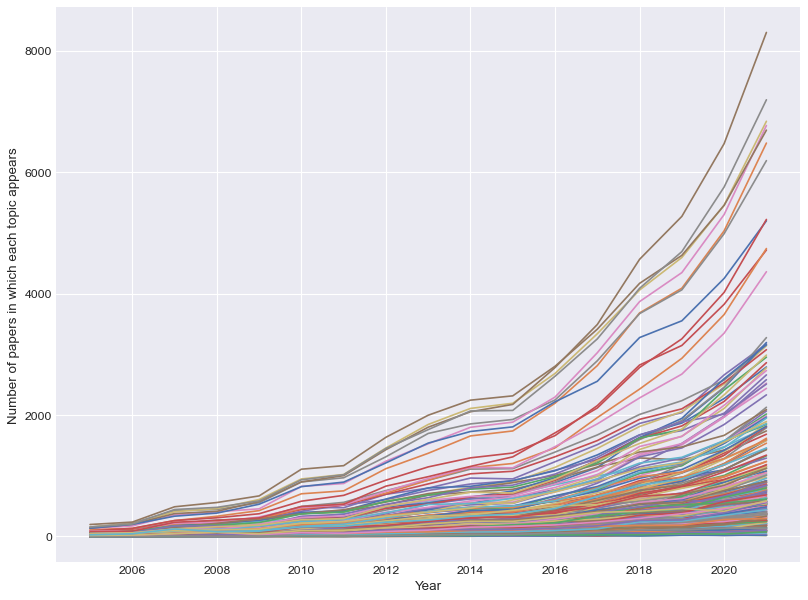

In [3228]:
plt.style.use('seaborn-darkgrid')
k = len(set(y_pred))
plt.figure(figsize=(12, 9), dpi=80)
for i in range(k):
    plt.plot(x_plotting, y_plotting[i], label=i)
#plt.legend()
plt.xlabel("Year")
plt.ylabel("Number of papers in which each topic appears")
plt.savefig("../Graphs/topicHits.png")

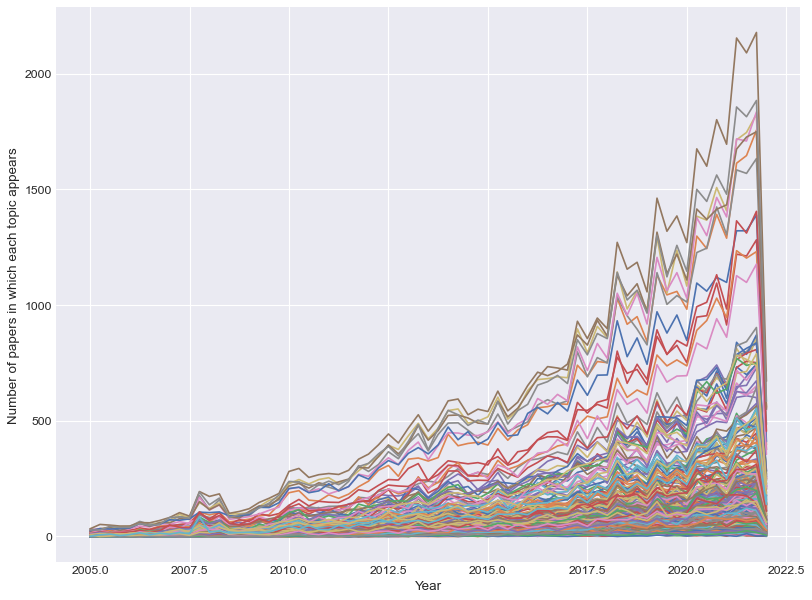

In [3229]:
k = len(set(y_pred))
plt.figure(figsize=(12, 9), dpi=80)
for i in range(len(y_plotting_quarter)):
    plt.plot(np.divide(x_plotting_quarter, 4), y_plotting_quarter[i], label=i)
#plt.legend()
plt.xlabel("Year")
plt.ylabel("Number of papers in which each topic appears")
plt.savefig("../Graphs/topicHitsQuarter.png")

In [3230]:
# Find how many abstracts there are per year
abstracts_per_year = {}
for index, row in df_combined.iterrows():
    if(row['year'] in abstracts_per_year.keys()):
        abstracts_per_year[row['year']] += 1
    else:
        abstracts_per_year[row['year']] = 1

# Find how many abstracts there are per quarter
abstracts_per_quarter = {}
for index, row in df_combined.iterrows():
    if(row['quarter'] in abstracts_per_quarter.keys()):
        abstracts_per_quarter[row['quarter']] += 1
    else:
        abstracts_per_quarter[row['quarter']] = 1

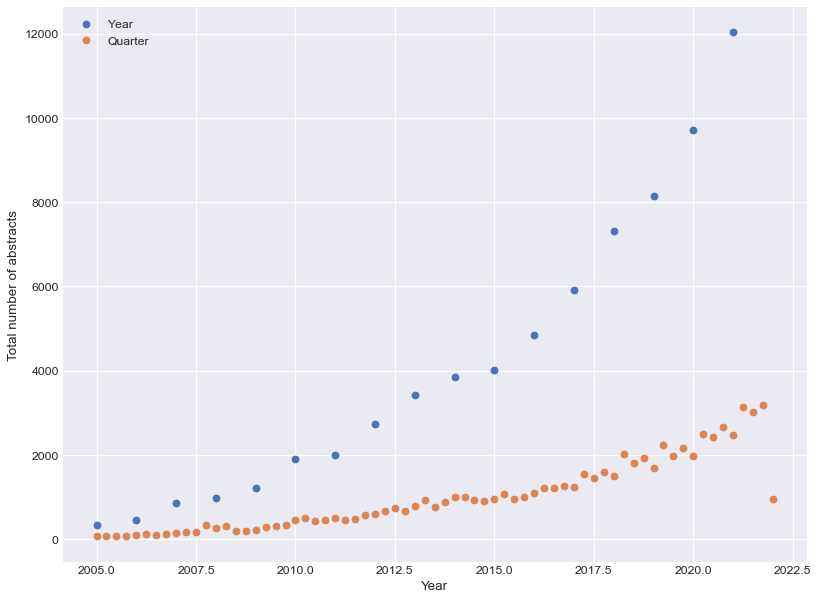

In [3231]:
plt.figure(figsize=(12, 9), dpi=80)
plt.scatter(list(abstracts_per_year.keys()), list(abstracts_per_year.values()), label='Year')
x_abstracts_per_quarter = np.array([int(q) for q in abstracts_per_quarter.keys()])
x_abstracts_per_quarter = np.divide(x_abstracts_per_quarter, 4)
plt.scatter(x_abstracts_per_quarter, list(abstracts_per_quarter.values()), label='Quarter')
plt.xlabel('Year')
plt.ylabel('Total number of abstracts')
plt.legend()
plt.savefig('../Graphs/Final/abstractsPerYear')

In [3232]:
#Normalization
hits_normalized_year = {}
for year in hits_per_year.keys():
    total = abstracts_per_year[year]
    hits_normalized_year[int(year)] = {}
    for key in hits_per_year[year].keys():
        hits_normalized_year[int(year)][key] = hits_per_year[year][key]/total

hits_normalized = {}
for quarter in hits_per_quarter.keys():
    total = abstracts_per_quarter[quarter]
    hits_normalized[int(quarter)] = {}
    for key in hits_per_quarter[quarter].keys():
        hits_normalized[int(quarter)][key] = hits_per_quarter[quarter][key]/total

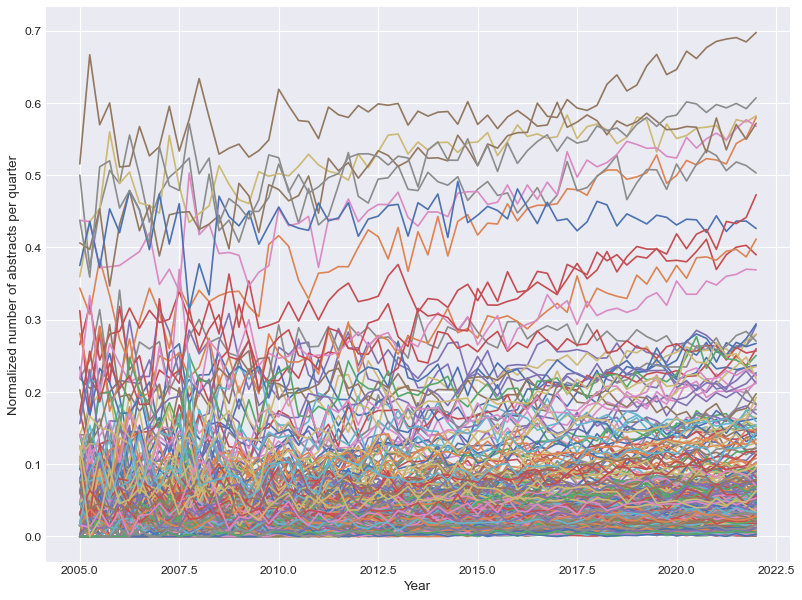

In [3233]:
x_p, y_p = plottingParams(hits_normalized)
plt.figure(figsize=(12, 9), dpi=80)
for i in range(k):
    plt.plot(np.divide(x_p,4), y_p[i], label=i)
plt.ylabel('Normalized number of abstracts per quarter')
plt.xlabel('Year')
plt.savefig('../Graphs/Final/hitsPerYear.png')

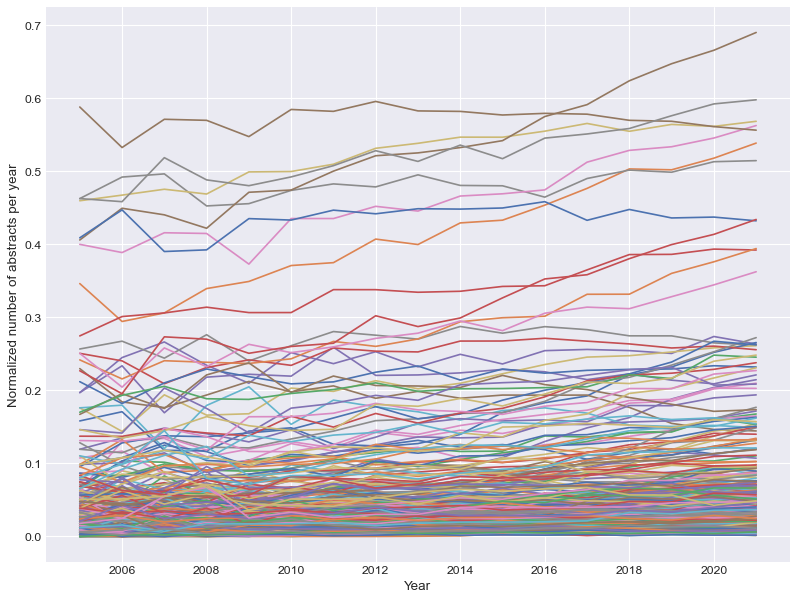

In [3234]:
x_p_year, y_p_year = plottingParams(hits_normalized_year)
plt.figure(figsize=(12, 9), dpi=80)
for i in range(k):
    plt.plot(x_p_year, y_p_year[i], label=i)
plt.ylabel('Normalized number of abstracts per year')
plt.xlabel('Year')
plt.savefig('../Graphs/Final/hitsPerYearYear.png')

Cut off data before 2005 and which appear fewer than 8 times per year

In [3235]:
def cutOff(hits_per_year, y):
    hits_new = {}
    for year in hits_per_year.keys():
        if(y):
            if(year >= 2005):
                hits_new[year] = {}
                for topic in hits_per_year[year]:
                    if hits_per_year[year][topic] > 8:
                        hits_new[year][topic] = hits_per_year[year][topic]
        else:
            if(year >= 8020):
                hits_new[year] = {}
                for topic in hits_per_year[year]:
                    if hits_per_year[year][topic] > 2:
                        hits_new[year][topic] = hits_per_year[year][topic]

    return hits_new

In [3236]:
def findTotalTopicsPerYear(hits_per_year):
    topics_per_year = {}
    for year in hits_per_year.keys():
        topics_per_year[year] = sum(hits_per_year[year].values())
    return topics_per_year

In [3237]:
def normalize(hits_per_year, abstracts_per_year):
    hits_normalized = {}
    for year in hits_per_year.keys():
        total = abstracts_per_year[year]
        hits_normalized[int(year)] = {}
        for key in hits_per_year[year].keys():
            hits_normalized[int(year)][key] = hits_per_year[year][key]/total
    return hits_normalized

In [3238]:
hits_per_quarter2 = cutOff(hits_per_quarter, False)
hits_normalized = normalize(hits_per_quarter2, abstracts_per_quarter)

In [3239]:
hits_per_quarter2

{8029: {195: 103,
  48: 96,
  47: 86,
  207: 84,
  105: 77,
  110: 70,
  56: 64,
  33: 52,
  14: 49,
  31: 45,
  80: 44,
  81: 42,
  183: 40,
  53: 38,
  4: 37,
  165: 36,
  27: 35,
  126: 34,
  194: 33,
  172: 32,
  248: 31,
  38: 28,
  140: 26,
  146: 26,
  199: 24,
  55: 24,
  59: 24,
  143: 23,
  134: 23,
  117: 23,
  40: 23,
  246: 22,
  84: 21,
  30: 20,
  211: 20,
  16: 19,
  178: 19,
  75: 19,
  26: 18,
  268: 17,
  203: 17,
  67: 17,
  299: 17,
  100: 17,
  269: 17,
  231: 17,
  22: 17,
  92: 16,
  157: 16,
  151: 16,
  288: 15,
  118: 14,
  180: 14,
  245: 14,
  208: 14,
  141: 14,
  77: 14,
  187: 13,
  139: 13,
  161: 13,
  116: 13,
  49: 12,
  283: 12,
  298: 12,
  24: 11,
  70: 11,
  15: 11,
  9: 11,
  94: 10,
  228: 10,
  23: 10,
  282: 10,
  102: 10,
  66: 10,
  25: 10,
  68: 10,
  254: 10,
  21: 10,
  45: 10,
  46: 10,
  135: 9,
  114: 9,
  87: 9,
  277: 9,
  253: 9,
  124: 9,
  62: 9,
  240: 9,
  226: 9,
  278: 9,
  237: 9,
  154: 8,
  225: 8,
  125: 8,
  89: 8,
  171

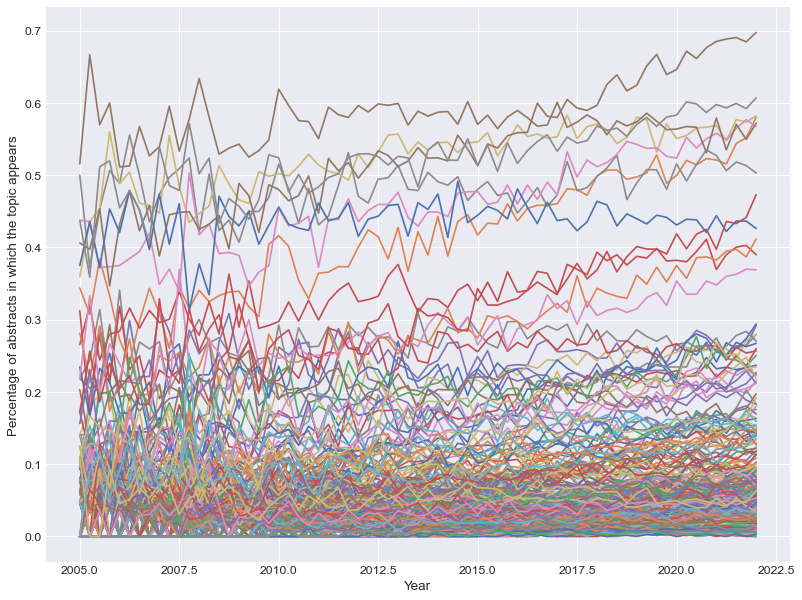

In [3240]:
plt.style.use('seaborn-darkgrid')
x_p, y_p = plottingParams(hits_normalized)
plt.figure(figsize=(12, 9), dpi=80)
for i in range(k):
    plt.plot(np.divide(x_p, 4), y_p[i], label=i)
plt.ylabel('Percentage of abstracts in which the topic appears')
plt.xlabel('Year')
plt.savefig('../Graphs/Final/hitsNormalizedCut.png')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Modelling subjects

In [3241]:
#Making time sequence for subjects
def makeTimeSeq(year_per_subject):
    time_seq = {}
    year_min = int(list(subject_per_year.keys())[-1])
    year_max = int(list(subject_per_year.keys())[0])
    for subj in year_per_subject.keys():
        arr = np.zeros(year_max-year_min+1)
        for year in year_per_subject[subj].keys():
            arr[year-year_min] = year_per_subject[subj][year]
        time_seq[subj] = arr
    return time_seq

In [3242]:
df_combined = df_combined.rename(columns={'sub_category':'subfield'})

In [3243]:
# Topic hits per year
# In this and that year I have this many IT, this many LG ...
def yearHits():
    hits_per_year = {}
    for index, row in df_combined.iterrows():
        if(row['quarter'] in hits_per_year.keys()):
            if(row['subfield'] in hits_per_year[row['quarter']].keys()):
                hits_per_year[row['quarter']][row['subfield']] += 1
            else:
                hits_per_year[row['quarter']][row['subfield']] = 1
        else:
            hits_per_year[row['quarter']] = {row['subfield'] : 1}
    for key in hits_per_year.keys():
        hits_per_year[key] = {k: v for k, v in sorted(dict(hits_per_year[key]).items(), key=lambda item: item[1], reverse=True)}

    hits_normalized = {}
    for year in hits_per_year.keys():
        total = 0
        hits_normalized[int(year)] = {}
        for key in hits_per_year[year].keys():
            total += hits_per_year[year][key]
        for key in hits_per_year[year].keys():
            hits_normalized[int(year)][key] = hits_per_year[year][key]/total
    
    hits_per_year = {k: v for k, v in sorted(dict(hits_per_year).items(), key=lambda item: item[0], reverse=True)}
    hits_normalized = {k: v for k, v in sorted(dict(hits_normalized).items(), key=lambda item: item[0], reverse=True)}

    return hits_per_year, hits_normalized

In [3244]:
subject_per_year, subject_per_year_norm = yearHits()

In [3245]:
# Convert dictionary
def year_to_subject(subject_per_year):
    year_per_subject = {}
    for year in subject_per_year.keys():
        d = subject_per_year[year]
        for subj in d.keys():
            if(subj in year_per_subject.keys()):
                year_per_subject[subj][year] = d[subj]
            else:
                year_per_subject[subj] = {year : d[subj]}
    return year_per_subject

In [3246]:
year_per_subject_norm = year_to_subject(subject_per_year_norm)
time_seq = makeTimeSeq(year_per_subject_norm)

In [3247]:
# Shorten time_seq to post 2005
def shortenTimeSeq(time_seq, y_p):
    ts2 = {}
    startingIndex = len(time_seq['AI'])-len(y_p[0])
    for subj in time_seq.keys():
        ts2[subj] = time_seq[subj][startingIndex:]
    return ts2

In [3248]:
time_seq = shortenTimeSeq(time_seq, y_p)

In [3249]:
def findSubjectTopicHits(topic, f):
    hits_per_field = {}
    for index, row in df_combined.iterrows():
        if(row[f] in hits_per_field.keys()):
            hits_per_field[row[f]] = Counter(hits_per_field[row[f]]) + Counter(row[topic])
        else:
            hits_per_field[row[f]] = Counter(row[topic])
    for key in hits_per_field.keys():
        hits_per_field[key] = {k: v for k, v in sorted(dict(hits_per_field[key]).items(), key=lambda item: item[1], reverse=True)}

    hits_normalized_field = {}
    for field in hits_per_field.keys():
        total = 0
        hits_normalized_field[field] = {}
        for key in hits_per_field[field].keys():
            total += hits_per_field[field][key]
        for key in hits_per_field[field].keys():
            hits_normalized_field[field][key] = hits_per_field[field][key]/total

    return hits_per_field, hits_normalized_field


In [3250]:
subject_no, subject_topic_hits = findSubjectTopicHits('topic_hits', 'subfield')
topics_no, subject_topics = findSubjectTopicHits('topics', 'subfield')

Determining how good the topics are

In [3251]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
# Multinomial Naive Bayes Classifier
def NBClassifier(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    y_pred = mnb.predict(X_test)
    y_pred_classes = mnb.predict_proba(X_test)
    classes = mnb.classes_
    return y_pred, y_pred_classes, y_test, classes

In [3252]:
#Mean Reciprocal Rank
def MRR(y_pred_classes, y_test, classes):
    s = 0
    for i in range(len(y_pred_classes)):
        classNum = list(classes).index(y_test[i])
        val = y_pred_classes[i][classNum]
        sorted_list = sorted(y_pred_classes[i], reverse=True)
        index = sorted_list.index(val)
        s += 1/(index+1)
    mrr = 1/len(y_pred_classes) * s
    return mrr

In [3253]:
def formDatafromDF(df_combined):
    X = np.zeros((len(df_combined['subfield']),k))
    i = 0
    y = ['']*len(df_combined['subfield'])
    for index, row in df_combined.iterrows():
        y[i] = str(row['subfield'])
        for key in row['topic_hits'].keys():
            X[i][key] = row['topic_hits'][key]
        i+=1
    return X, y

In [3254]:
def formDatafromDF2(df_combined):
    X = np.zeros((len(df_combined['subfield']),k))
    i = 0
    y = ['']*len(df_combined['subfield'])
    for index, row in df_combined.iterrows():
        y[i] = str(row['subfield'])
        for topic in row['topics']:
            X[i][topic] = 1
        i+=1
    return X, y

In [3255]:
X_df, y_df = formDatafromDF(df_combined)

In [3256]:
X_df2, y_df2 = formDatafromDF2(df_combined)

In [3257]:
y_pred, y_pred_classes, y_test, classes = NBClassifier(X_df, y_df)

In [3258]:
y_pred2, y_pred_classes2, y_test2, classes2 = NBClassifier(X_df2, y_df2)

In [3259]:
mrr = MRR(y_pred_classes, y_test, classes)
mrr2 = MRR(y_pred_classes2, y_test2, classes2)
print(mrr, mrr2)

0.6204516957960231 0.6252720824699904


In [3260]:
#Randomised allocation performance
from random import randint
s = 0
for i in range(len(y_pred_classes)):
    classNum = randint(0,39)
    val = y_pred_classes[i][classNum]
    sorted_list = sorted(y_pred_classes[i], reverse=True)
    index = sorted_list.index(val)
    s += 1/(index+1)
mrrRandom = 1/len(y_pred_classes) * s
print(mrrRandom)

0.10660189344134634


Tf-Idf

In [3261]:
def tf_idf(subject_no):
    #Inverts keys e.g. {IT: {162: 123}} to {162: {IT: 123}}    
    subject_per_topic = year_to_subject(subject_no)
    #df
    df = {}
    for topic in subject_per_topic.keys():
        df[topic] = len(subject_per_topic[topic].keys())
    #idf
    idf = {}
    for topic in df.keys():
        idf[topic] = np.log10(len(subject_no.keys())/(df[topic]+1))

    # print("idf: ", idf)
    
    #tf
    tfIdf = {}
    for subj in subject_no.keys():
        tfIdf[subj] = {}
        for topic in subject_no[subj].keys():
            t_in_d = subject_no[subj][topic]
            all_in_d = len(subject_no[subj].keys())
            tf = t_in_d/all_in_d
            #print("tf: ", tf)
            tfIdf[subj][topic] = tf*idf[topic]
    
    for key in tfIdf.keys():
        tfIdf[key] = {k: v for k, v in sorted(dict(tfIdf[key]).items(), key=lambda item: item[1], reverse=True)}

    return tfIdf


In [3262]:
tfIdf = tf_idf(topics_no)

In [3263]:
def cutOffSubjectTopics(subject_topic_hits):
    sth = {}
    for subj in subject_topic_hits.keys():
        sth[subj] = {}
        total = 0
        for topic in subject_topic_hits[subj].keys():
            if(subject_topic_hits[subj][topic]>=0.01):
                sth[subj][topic] = subject_topic_hits[subj][topic]
                total += subject_topic_hits[subj][topic]
        for topic in sth[subj]:
            sth[subj][topic] = sth[subj][topic]/total
        
    return sth

In [3264]:
sth = cutOffSubjectTopics(subject_topics)

In [3265]:
def formCutOffSubjectNo(subject_no, sth):
    subject_no2 = {}
    for subj in subject_no.keys():
        subject_no2[subj] = {}
        for topic in subject_no[subj].keys():
            if(topic in sth[subj].keys()):
                subject_no2[subj][topic] = subject_no[subj][topic]
    return subject_no2

In [3266]:
topics_no2 = formCutOffSubjectNo(topics_no, sth)

In [3267]:
tfIdf = tf_idf(topics_no2)

In [3268]:
def findTopTfIdf(tfIdf, threshold):
    topTfIdf = {}
    for subj in tfIdf.keys():
        topTfIdf[subj] = dict(list(tfIdf[subj].items())[:threshold])
    return topTfIdf

In [3269]:
topTfIdf = findTopTfIdf(tfIdf, 10)

Investigating Autocorrelation and stuff

In [3270]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [3566]:
from statsmodels.tsa.stattools import adfuller
def calcAdFuller(seq):
    result = adfuller(seq)
    print('0th ADF Statistic: %f' % result[0], 'p-value: %f' % result[1])
    first_diff = np.diff(seq)
    second_diff = np.diff(seq, n=2)
    afv1 = adfuller(first_diff)
    afv2 = adfuller(second_diff)
    stat = first_diff
    print(len(stat))
    print('1st ADF Statistic: %f' % afv1[0], 'p-value: %f' % afv1[1])
    print('2nd ADF Statistic: %f' % afv2[0], 'p-value: %f' % afv2[1])
    #return result[1], afv1[1], afv2[1]
    return stat

In [3567]:
time_seq_diff = {}
for key in time_seq.keys():
    print(key)
    time_seq_diff[key] = calcAdFuller(time_seq[key])

CV
0th ADF Statistic: 1.486460 p-value: 0.997474
68
1st ADF Statistic: -2.279573 p-value: 0.178641
2nd ADF Statistic: -4.839279 p-value: 0.000046
LG
0th ADF Statistic: 1.865968 p-value: 0.998471
68
1st ADF Statistic: -8.290141 p-value: 0.000000
2nd ADF Statistic: -6.085997 p-value: 0.000000
CL
0th ADF Statistic: 1.299204 p-value: 0.996604
68
1st ADF Statistic: -4.185899 p-value: 0.000696
2nd ADF Statistic: -5.382042 p-value: 0.000004
SD
0th ADF Statistic: 1.003972 p-value: 0.994308
68
1st ADF Statistic: -6.744746 p-value: 0.000000
2nd ADF Statistic: -4.723028 p-value: 0.000076
AR
0th ADF Statistic: -7.620597 p-value: 0.000000
68
1st ADF Statistic: -3.421969 p-value: 0.010232
2nd ADF Statistic: -8.527086 p-value: 0.000000
RO
0th ADF Statistic: 0.577339 p-value: 0.987044
68
1st ADF Statistic: -1.728206 p-value: 0.416642
2nd ADF Statistic: -5.560767 p-value: 0.000002
IR
0th ADF Statistic: -2.471173 p-value: 0.122647
68
1st ADF Statistic: -6.985653 p-value: 0.000000
2nd ADF Statistic: -6.1

In [3568]:
x_p_diff = x_p[1:]

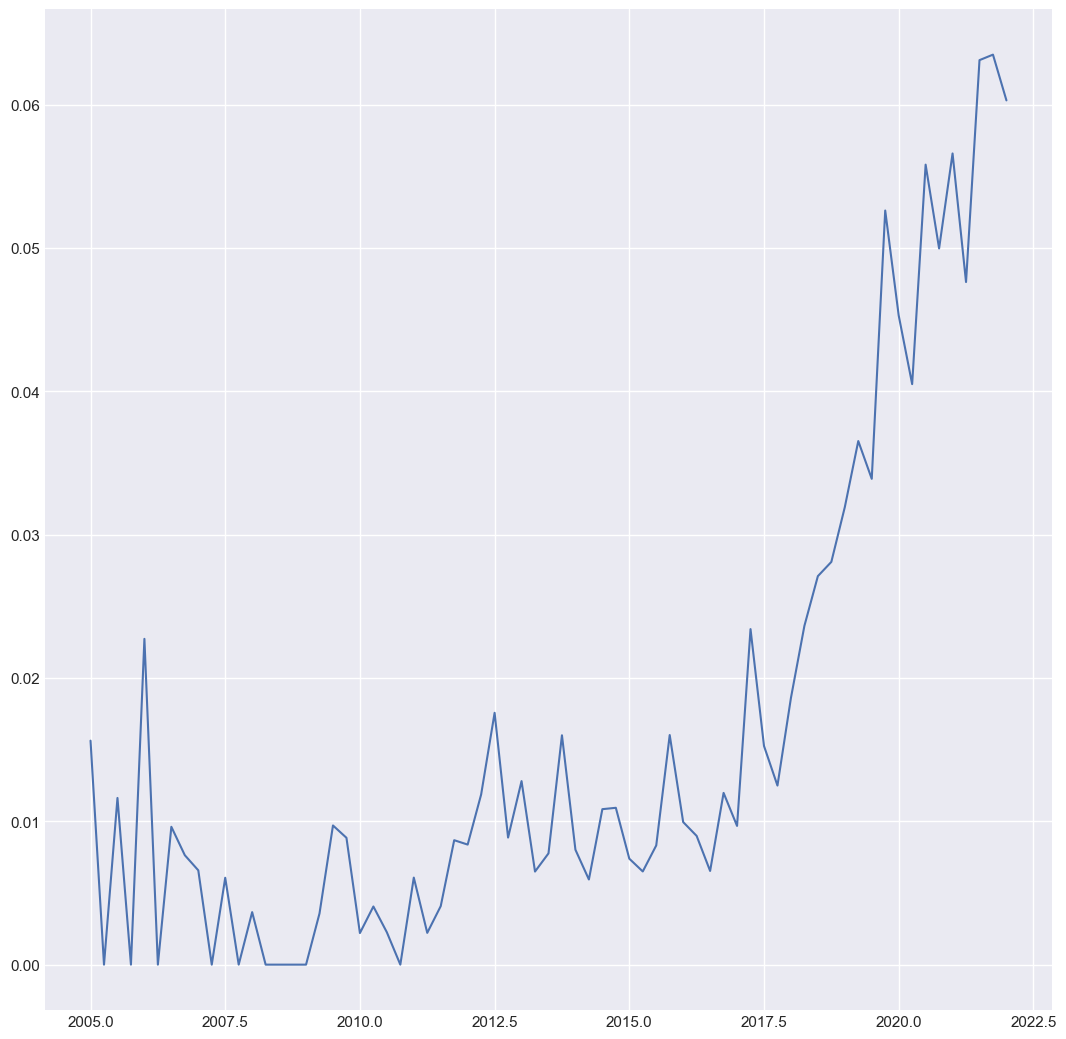

In [3569]:
plt.plot(np.divide(x_p, 4), time_seq['LG'])
plt.savefig('../Graphs/Final/LGseq.png')

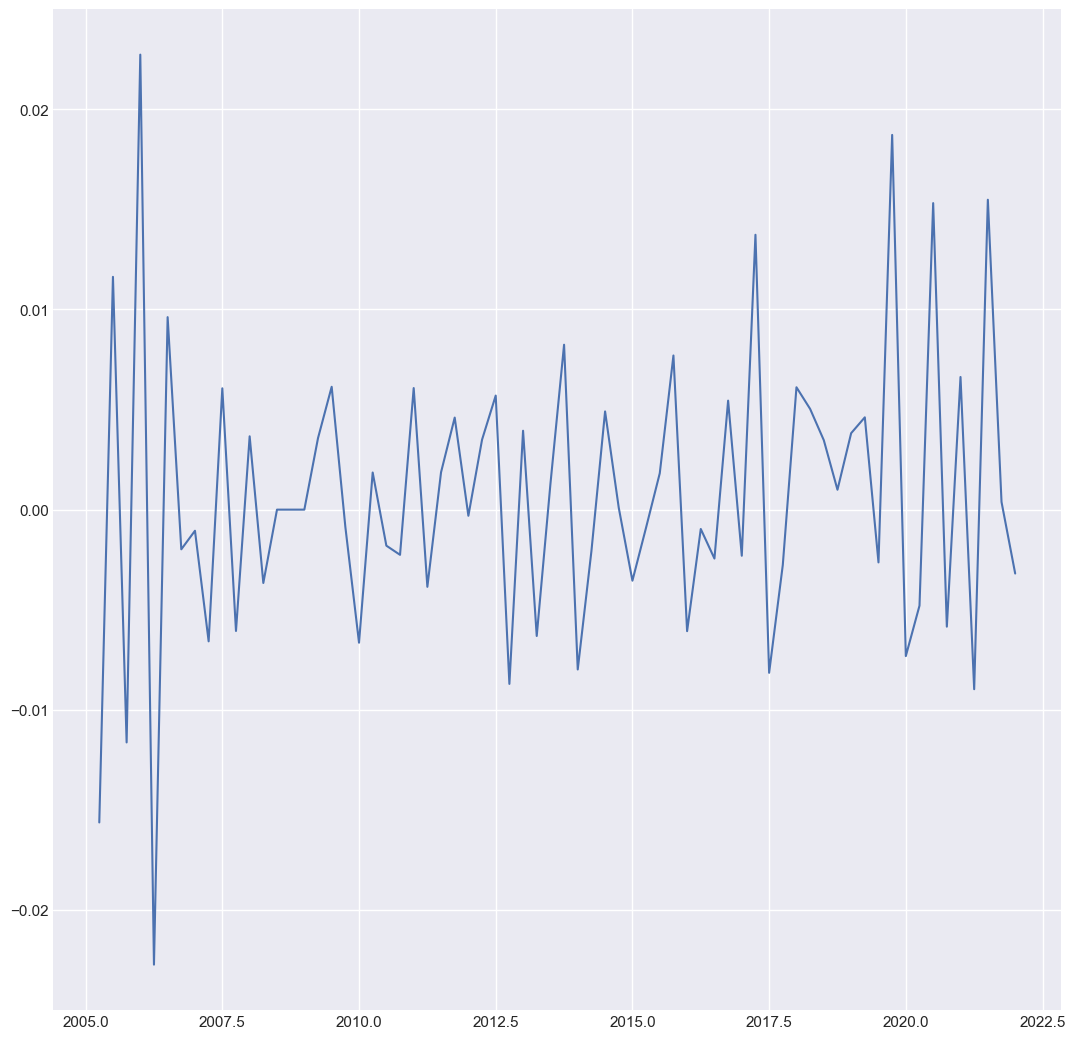

In [3570]:
plt.plot(np.divide(x_p_diff, 4),time_seq_diff['LG'])
plt.savefig('../Graphs/Final/LGseqDiff.png')

In [3571]:
y_p_diff = np.zeros((len(y_p), len(y_p[0])-1))
for i in range(len(y_p)):
    y_p_diff[i] = calcAdFuller(y_p[i])

0th ADF Statistic: -2.328805 p-value: 0.162846
68
1st ADF Statistic: -7.745240 p-value: 0.000000
2nd ADF Statistic: -10.611728 p-value: 0.000000
0th ADF Statistic: 0.852444 p-value: 0.992437
68
1st ADF Statistic: -7.738315 p-value: 0.000000
2nd ADF Statistic: -7.854134 p-value: 0.000000
0th ADF Statistic: -2.455398 p-value: 0.126707
68
1st ADF Statistic: -4.394502 p-value: 0.000304
2nd ADF Statistic: -2.527643 p-value: 0.108892
0th ADF Statistic: -10.642081 p-value: 0.000000
68
1st ADF Statistic: -5.949818 p-value: 0.000000
2nd ADF Statistic: -7.227559 p-value: 0.000000
0th ADF Statistic: -5.704921 p-value: 0.000001
68
1st ADF Statistic: -4.426549 p-value: 0.000266
2nd ADF Statistic: -5.645331 p-value: 0.000001
0th ADF Statistic: -4.155966 p-value: 0.000782
68
1st ADF Statistic: -4.553189 p-value: 0.000157
2nd ADF Statistic: -5.225309 p-value: 0.000008
0th ADF Statistic: -2.364863 p-value: 0.151900
68
1st ADF Statistic: -6.122634 p-value: 0.000000
2nd ADF Statistic: -5.392142 p-value: 

In [3879]:
#Seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
def testSeasonality(seq):
    decompose_result_mult = seasonal_decompose(seq, period=1)
    decompose_result_mult.plot()

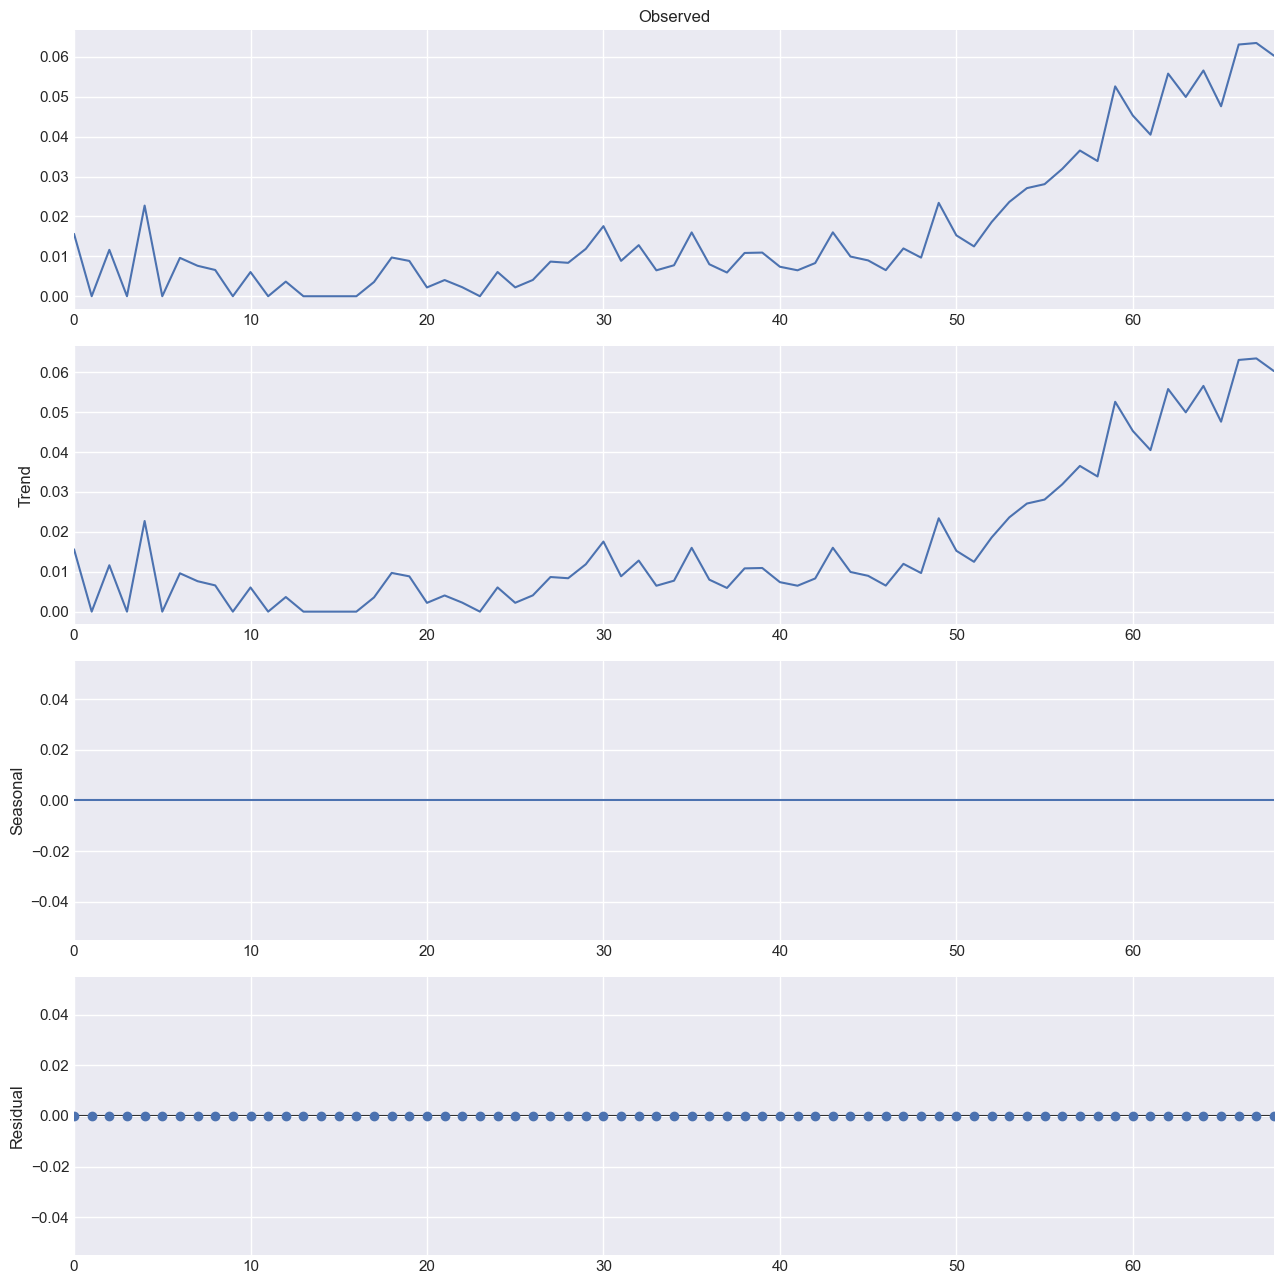

In [3886]:
testSeasonality(time_seq['LG'])
plt.savefig('../Graphs/Final/seasonality.png')

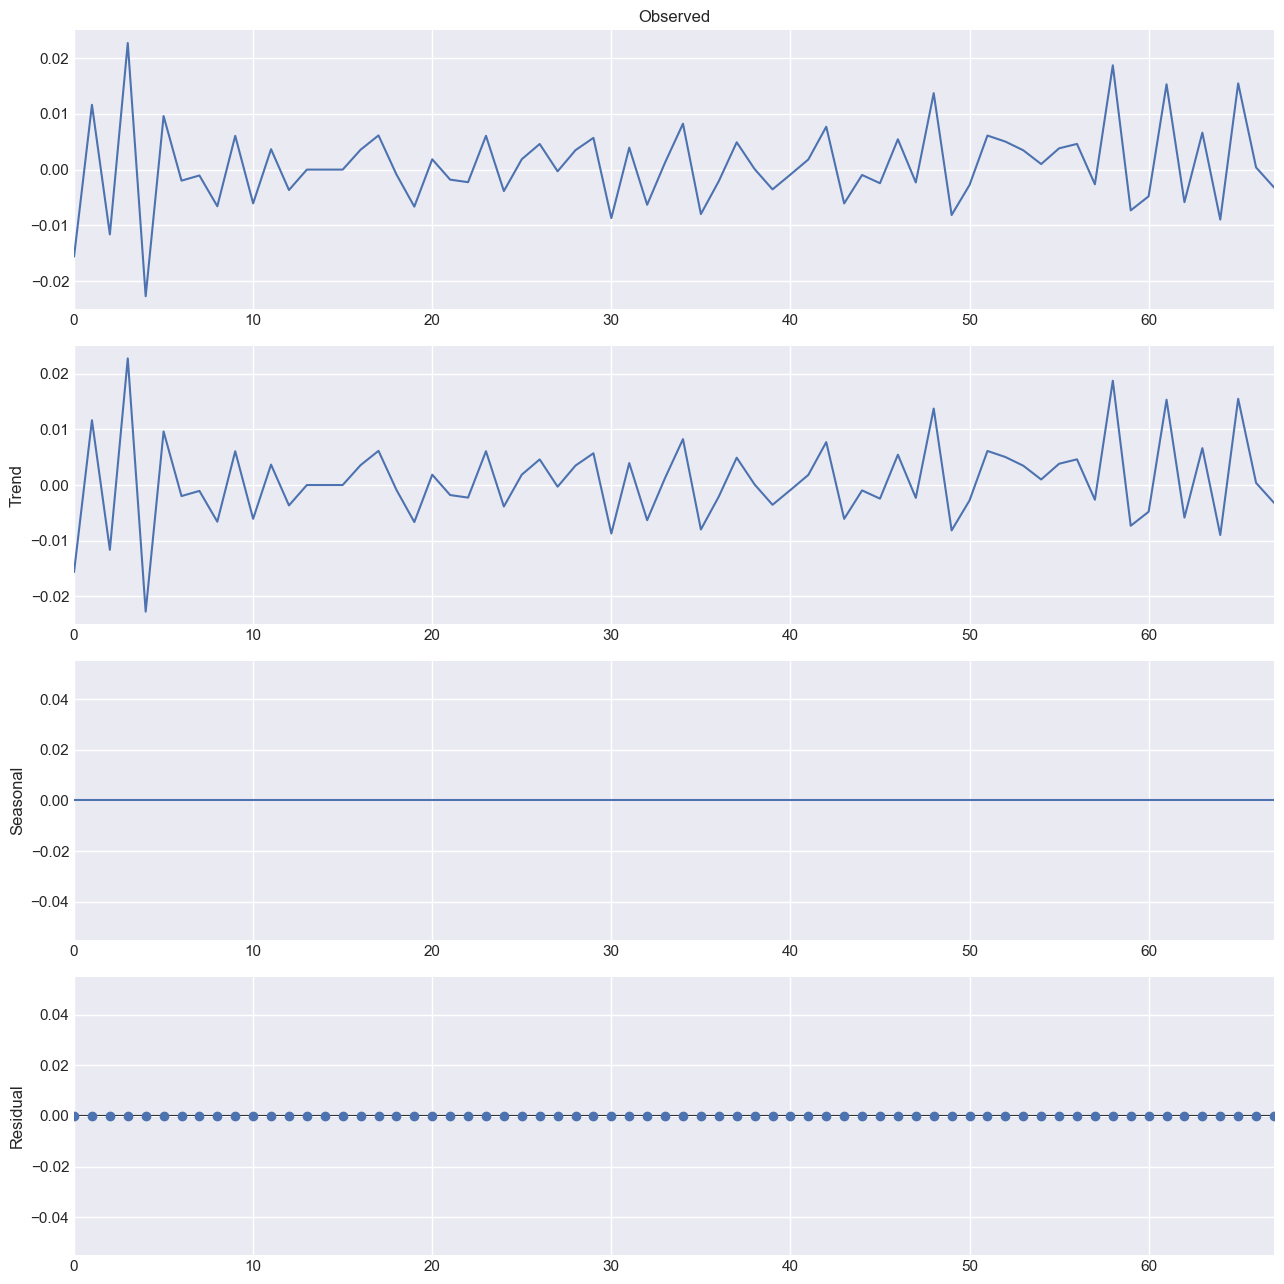

In [3883]:
testSeasonality(time_seq_diff['LG'])
#plt.figure(figsize=(12, 9), dpi=80)
plt.savefig('../Graphs/Final/seasonality_diff.png')

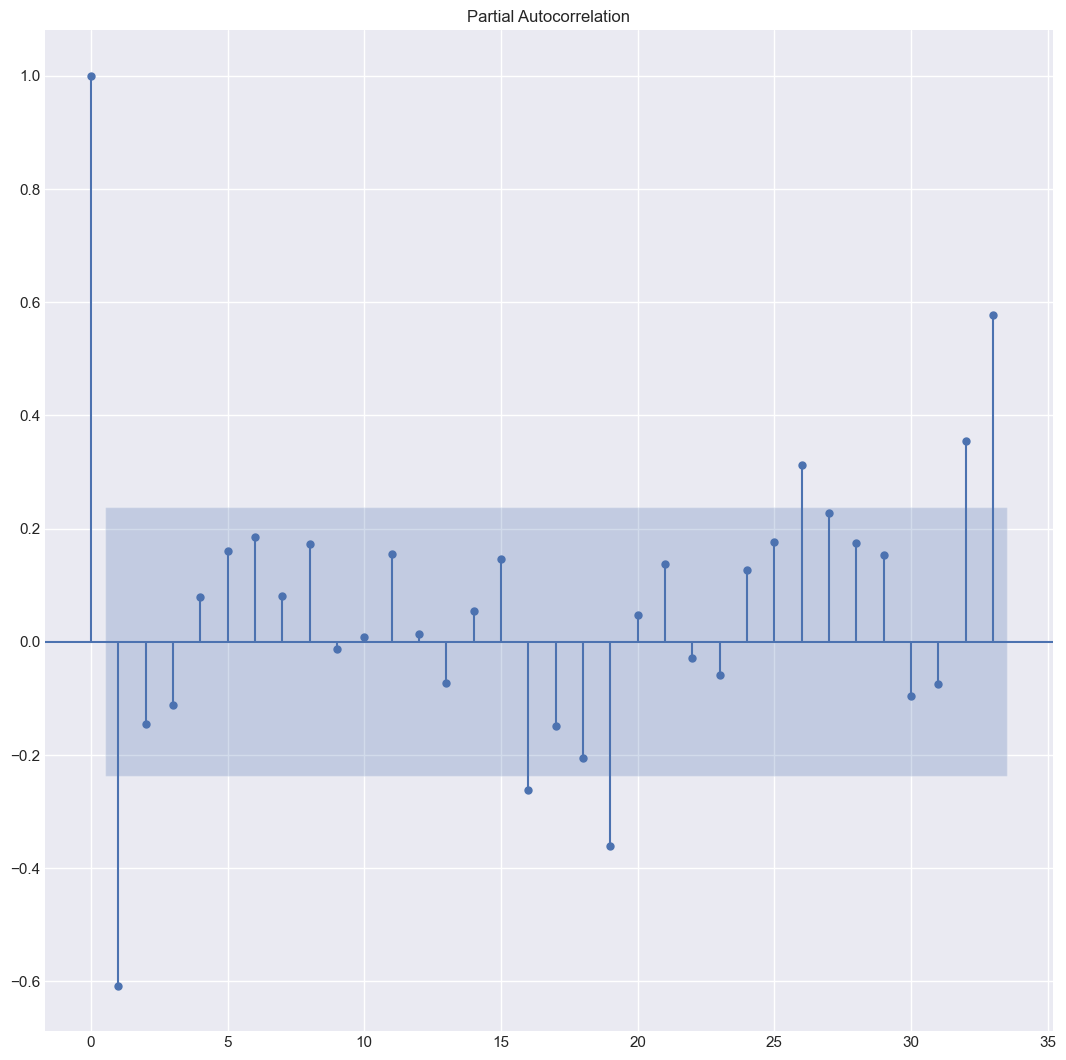

In [3887]:
# AR parameters
plot_pacf(time_seq_diff['LG'], lags = 33)
plt.savefig('../Graphs/Final/pacf_quarter.png')

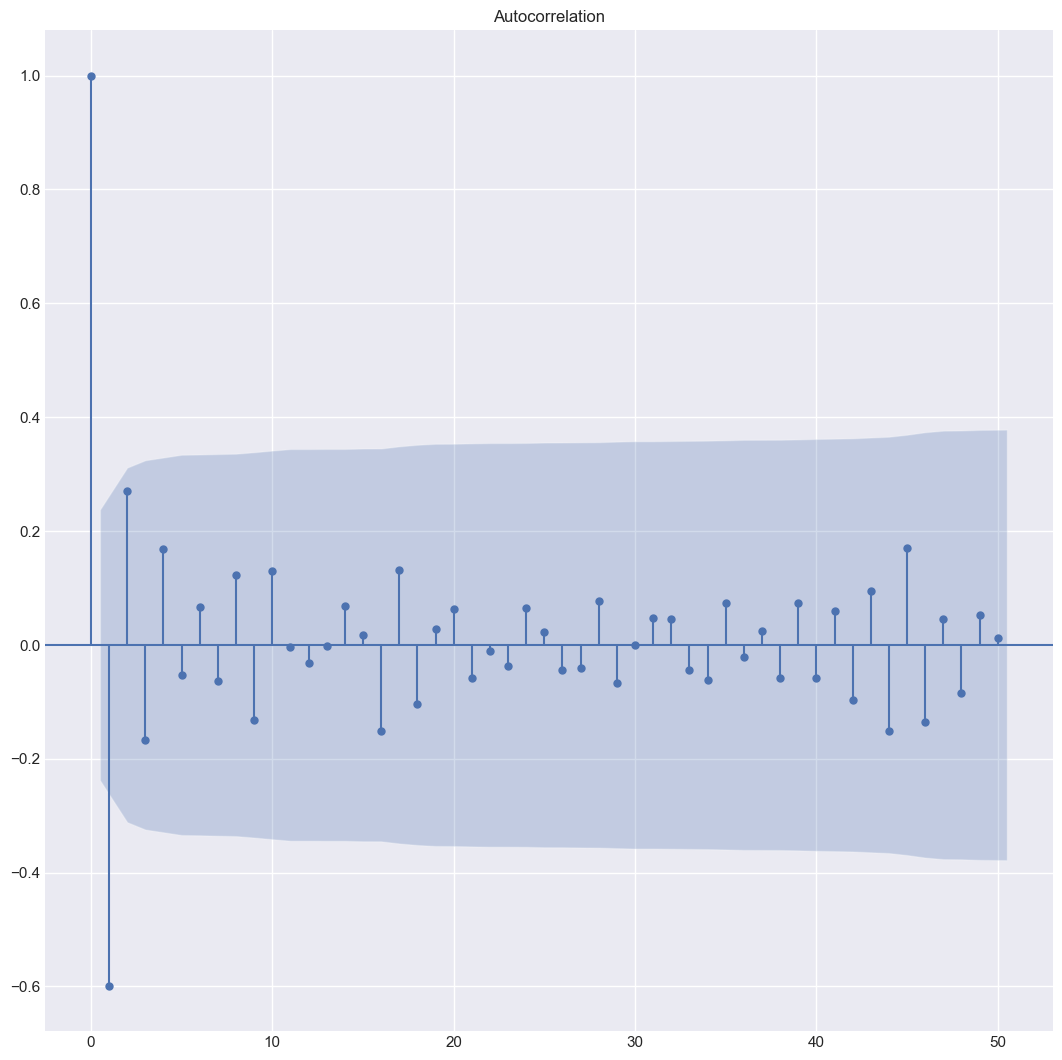

In [3888]:
# MA Parameters
plot_acf(time_seq_diff['LG'], lags = 50)
plt.savefig('../Graphs/Final/acf_quarter.png')

Time Series Analysis

In [3797]:
#ARIMA function
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error
def arima_func(series):
    #Forcasting
    X = series
    size = int(len(X)-8)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    model = ARIMA(history, order=(48,1,1))
    model_fit = model.fit()
    fc = model_fit.forecast(len(test), alpha=0.05)
    predictions = fc

    # evaluate forecasts
    rmse = sqrt(mean_squared_error(test, predictions))
    
    return predictions, rmse, train, test

In [3862]:
def plotArima(train, test, fc):
    test = np.insert(test,0,train[-1])
    fc = np.insert(fc,0,train[-1])
    # Make as pandas series
    train_series = pd.Series(train, index =np.divide(x_p[:-len(test)+1],4))
    train_index = train_series.index
    fc_series = pd.Series(fc, index = np.divide(x_p[-len(test):],4))
    #lower_series = pd.Series(conf[:, 0], index=test.index)
    #upper_series = pd.Series(conf[:, 1], index=test.index)
    # Plot
    test_series = pd.Series(test, index = np.divide(x_p[-len(test):],4))
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train_series, label='training')
    plt.plot(test_series, label='actual')
    plt.plot(fc_series, label='forecast')
    #plt.fill_between(lower_series.index, lower_series, upper_series, 
    #                color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='lower right', fontsize=8)
    plt.show()

In [3848]:
def plotComparison(sequence, prediction):
    size = int(len(sequence)-len(prediction))
    test = sequence[size:len(sequence)]
    plt.figure(figsize=(12, 9), dpi=80)
    plt.style.use('seaborn-darkgrid')
    plt.plot(np.divide(x_p[-len(test)-1:-1], 4), test, label='Data')
    plt.plot(np.divide(x_p[-len(test)-1:-1], 4), prediction, color='red', label='Predictions')
    plt.legend()

Baseline Predictions

In [3800]:
# ARIMA on subjects

subject_predictions_list = {}
rmse_original = {}
train = {}
test = {}

for subj in time_seq.keys():
    subject_predictions_list[subj], rmse_original[subj], train[subj], test[subj] = arima_func(time_seq[subj])

    #if(subj == 'LG'):
        #plotArima(train, test, subject_predictions_list[subj], conf)

/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

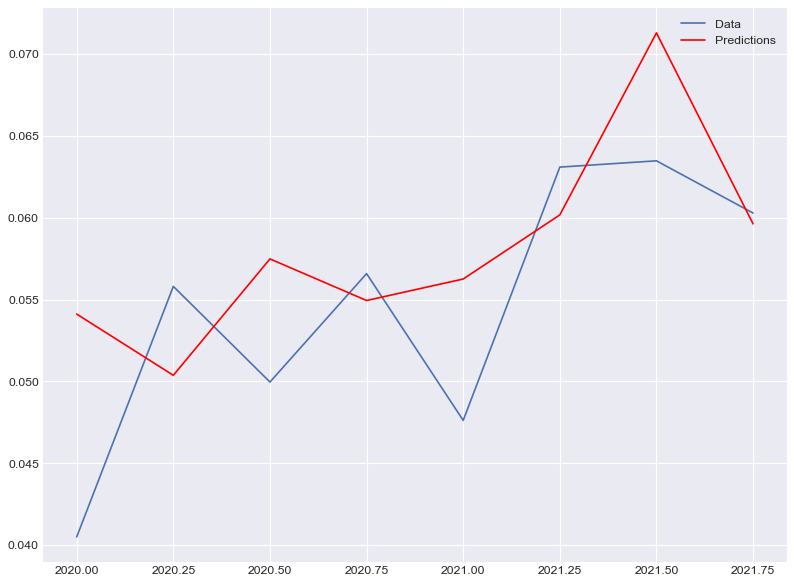

In [3849]:
plotComparison(test['LG'], subject_predictions_list['LG'])

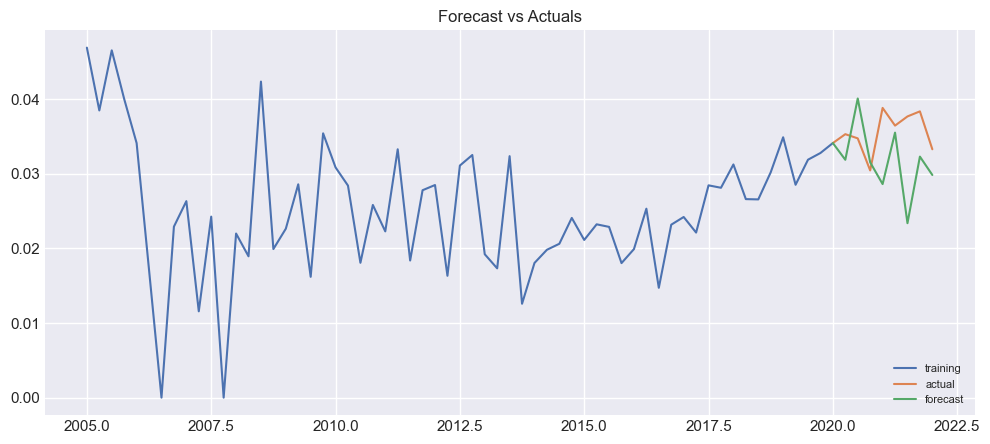

In [3863]:
plotArima(train['CR'], test['CR'], subject_predictions_list['CR'])

Method 1 - VAR
Assumes dependence

In [3803]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [3804]:
#Investigate topics
#Apply differencing, AR, MA

In [3805]:
y_p_diff = np.zeros((len(y_p), len(y_p[0])-1))
for i in range(len(y_p)):
    print(i)
    y_p_diff[i] = calcAdFuller(y_p[i])

0
0th ADF Statistic: -2.328805 p-value: 0.162846
68
1st ADF Statistic: -7.745240 p-value: 0.000000
2nd ADF Statistic: -10.611728 p-value: 0.000000
1
0th ADF Statistic: 0.852444 p-value: 0.992437
68
1st ADF Statistic: -7.738315 p-value: 0.000000
2nd ADF Statistic: -7.854134 p-value: 0.000000
2
0th ADF Statistic: -2.455398 p-value: 0.126707
68
1st ADF Statistic: -4.394502 p-value: 0.000304
2nd ADF Statistic: -2.527643 p-value: 0.108892
3
0th ADF Statistic: -10.642081 p-value: 0.000000
68
1st ADF Statistic: -5.949818 p-value: 0.000000
2nd ADF Statistic: -7.227559 p-value: 0.000000
4
0th ADF Statistic: -5.704921 p-value: 0.000001
68
1st ADF Statistic: -4.426549 p-value: 0.000266
2nd ADF Statistic: -5.645331 p-value: 0.000001
5
0th ADF Statistic: -4.155966 p-value: 0.000782
68
1st ADF Statistic: -4.553189 p-value: 0.000157
2nd ADF Statistic: -5.225309 p-value: 0.000008
6
0th ADF Statistic: -2.364863 p-value: 0.151900
68
1st ADF Statistic: -6.122634 p-value: 0.000000
2nd ADF Statistic: -5.39

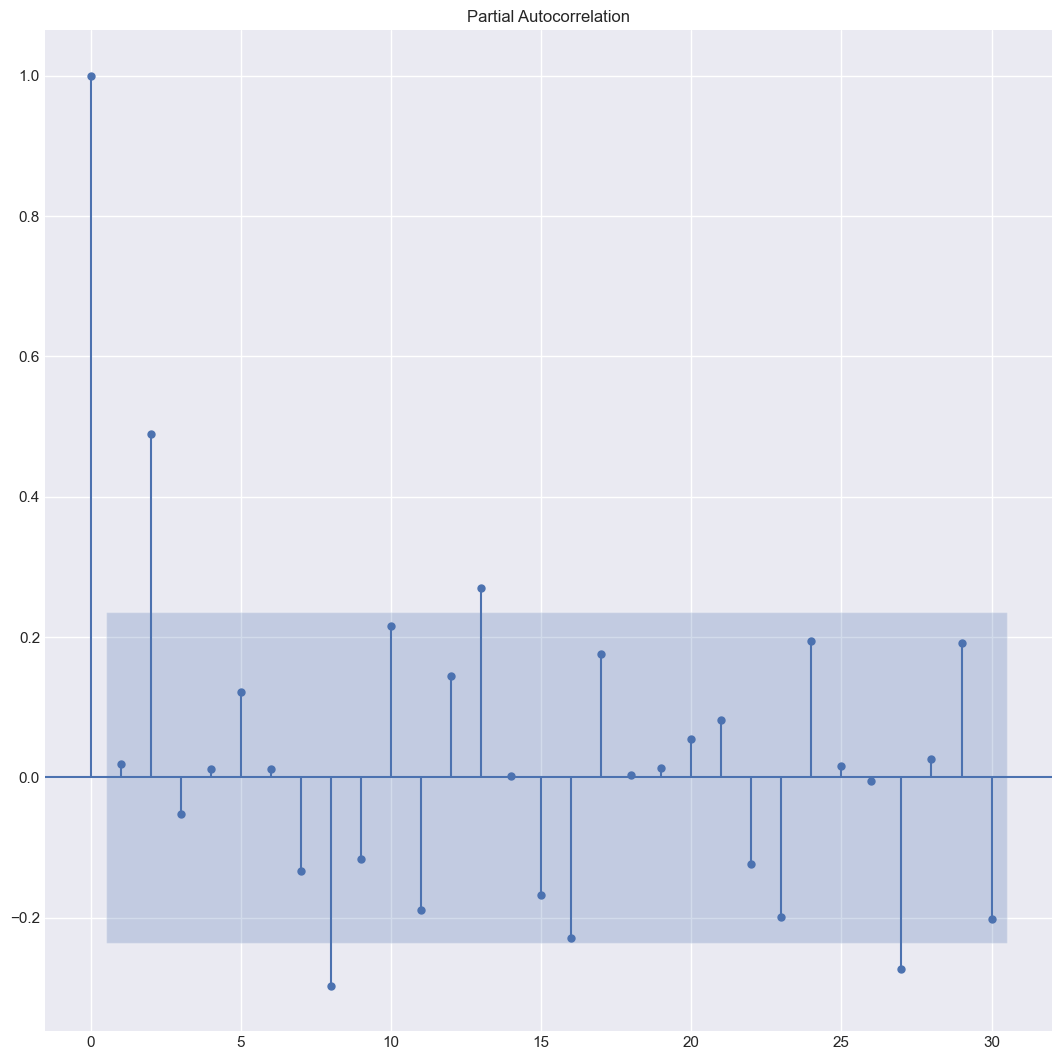

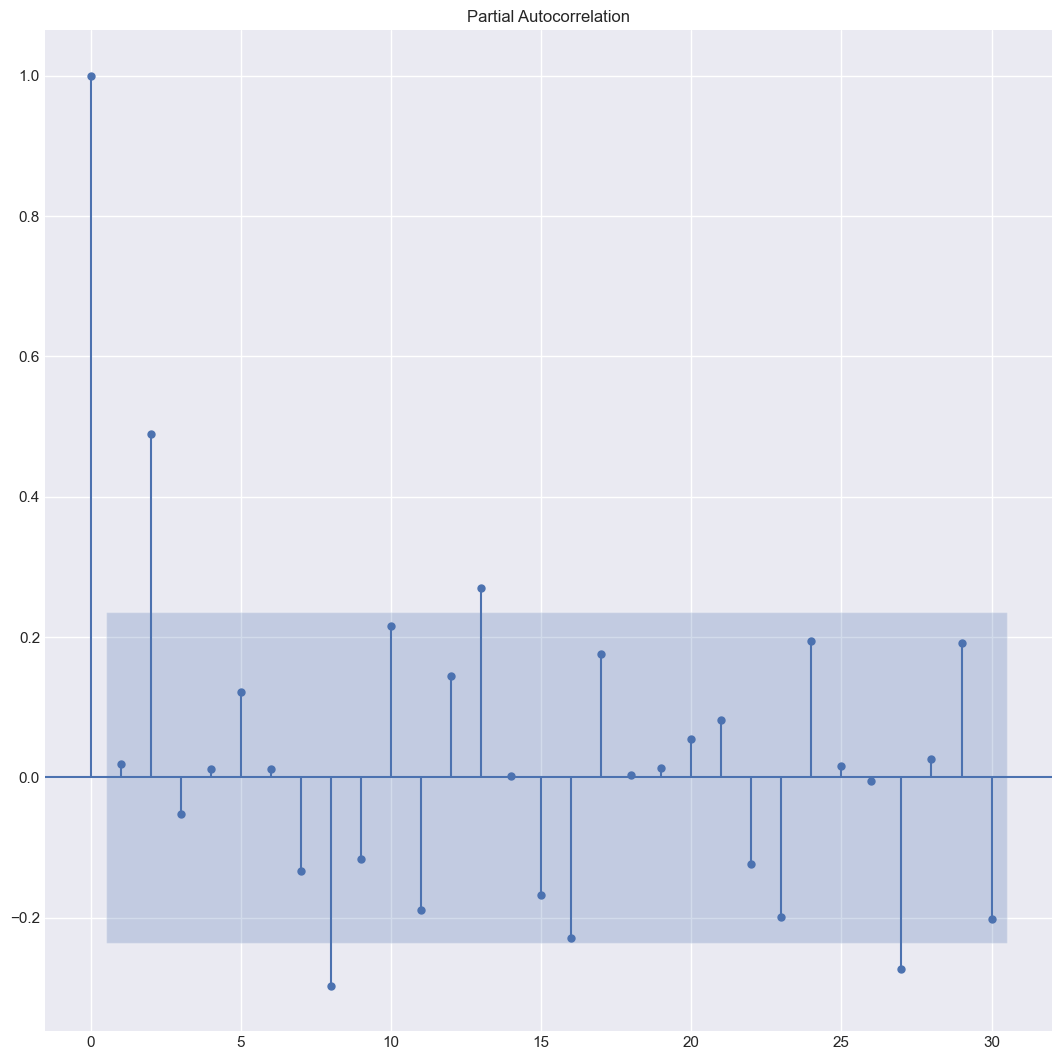

In [3806]:
plot_pacf(y_p[2], lags=30)

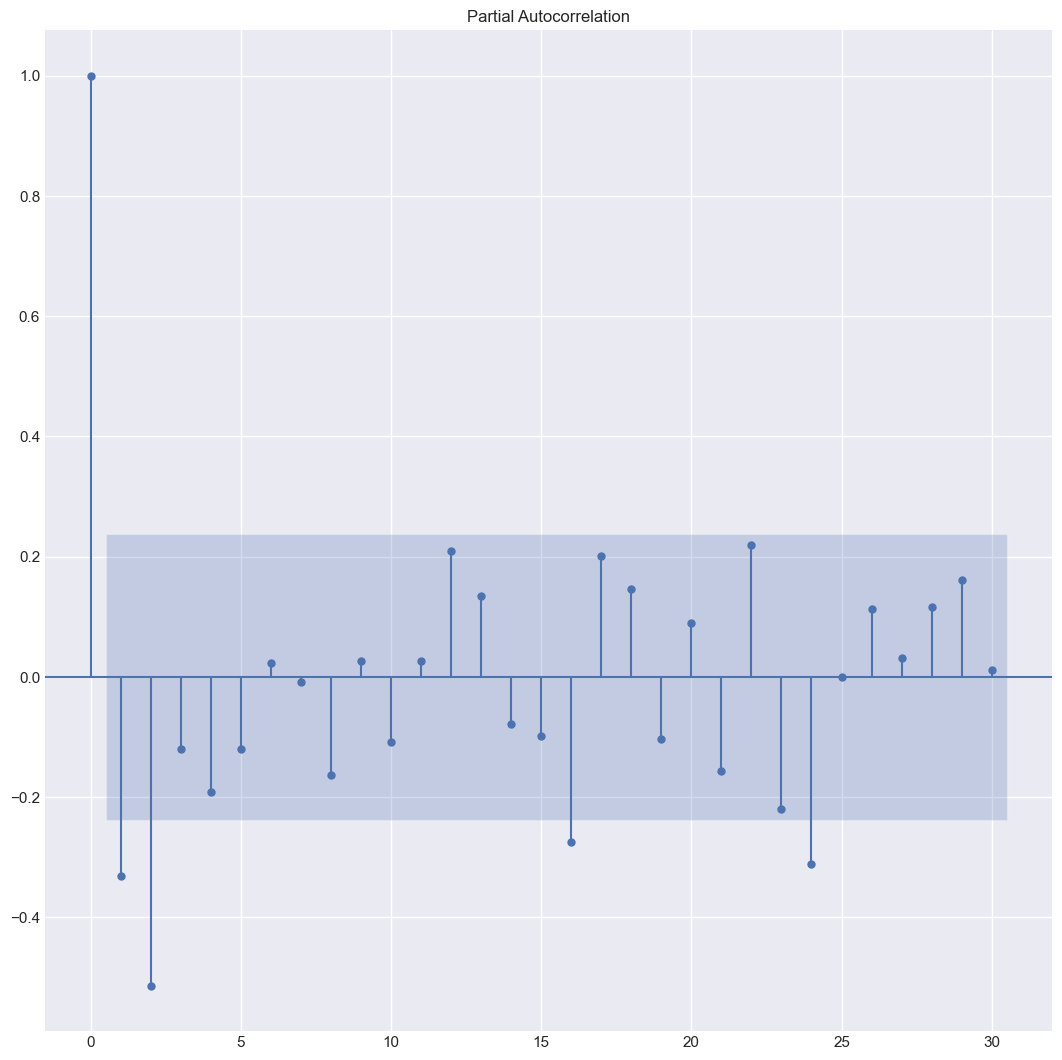

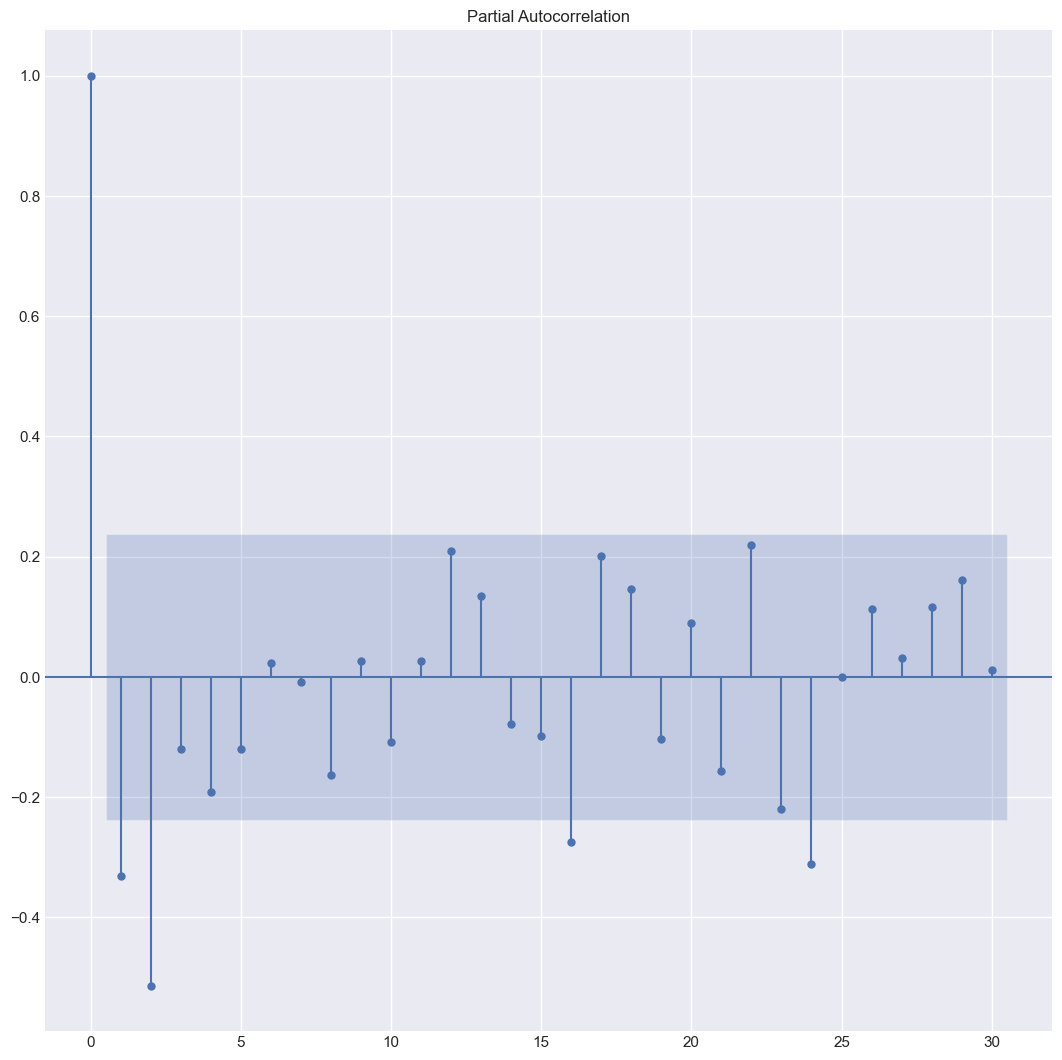

In [3807]:
plot_pacf(y_p_diff[3], lags = 30)

VAR implementation

In [3808]:
def var_func(pd_topics, cols, y):
    X = pd_topics[cols]
    indices = X.index.values.tolist()
    y_df = pd.DataFrame(y, index=indices, columns=['y'])
    X.insert(0,'y', y_df)
    size = int(len(X)-8)
    train, test = X[0:size][:], X[size:len(X)][:]
    mod = VAR(endog=train)
    model_fit = mod.fit(48)
    prediction = model_fit.forecast(model_fit.y, steps=len(test))

    pred = np.array(prediction).T
    rmse = sqrt(mean_squared_error(test['y'], pred[0]))
    return pred[0], rmse, test, train

In [3809]:
pd_topics = pd.DataFrame(y_p_diff.T, index = x_p[1:], columns = range(k))
pd_topics_transposed = pd_topics.T

In [3810]:
pd_topics_full = pd.DataFrame(y_p.T, index = x_p, columns = range(k))

In [3811]:
var_pred = {}
rmse_var = {}
test_var = {}
train_var = {}
for subj in topTfIdf.keys():
    cols = list(topTfIdf[subj].keys())
    var_pred[subj], rmse_var[subj], test_var[subj], train_var[subj] = var_func(pd_topics, cols=cols, y=time_seq_diff[subj])

/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ba

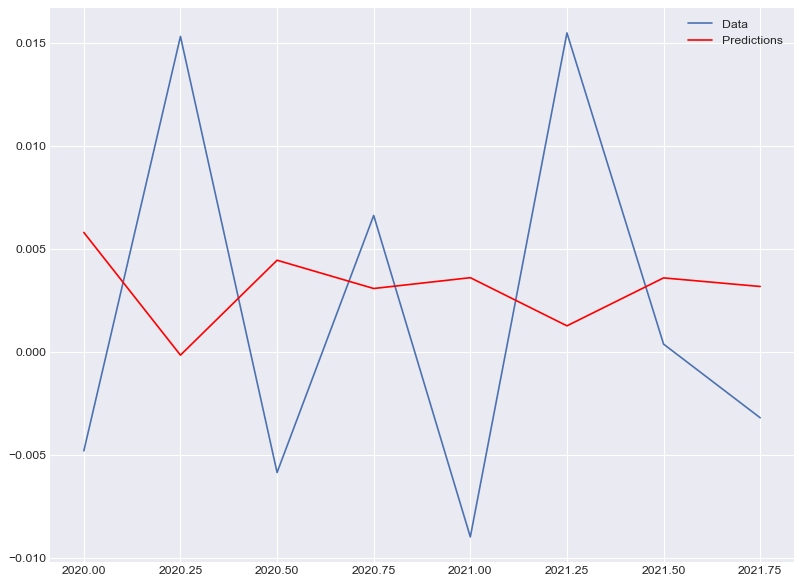

In [3864]:
plotComparison(list(test_var['LG']['y']), list(var_pred['LG']))

In [3865]:
plotArima(list(train_var['LG']['y']), list(test_var['LG']['y']), var_pred['LG'])

ValueError: Length of values (60) does not match length of index (61)

In [3814]:
#Put it back from differencing

In [3815]:
def invert_transformation(train_var, var_pred, time_seq):
    """Revert back the differencing to get the forecast to original scale."""
    var_pred_full = {}
    rmse = {}
    for key in train_var.keys():
        rmse[key] = 0
        for i in range(len(var_pred[key])):
            if(i==0):
                var_pred_full[key] = np.zeros(len(var_pred[key]))
                var_pred_full[key][i] = time_seq[key][-8]+var_pred[key][i]
            else:
                var_pred_full[key][i] = var_pred_full[key][i-1] + var_pred[key][i]
        rmse[key] = sqrt(mean_squared_error(time_seq[key][-8:], var_pred_full[key]))

    return var_pred_full, rmse

In [3816]:
var_pred['CL']

array([ 0.01107558,  0.00223888,  0.00647374, -0.00401471,  0.00176755,
        0.00354798,  0.00082907, -0.00077921])

In [3817]:
tmplist = range(8)
print(list(tmplist))
tmplist[-8]

[0, 1, 2, 3, 4, 5, 6, 7]


0

In [3818]:
var_pred_full, rmse_var_full = invert_transformation(train_var, var_pred, time_seq)

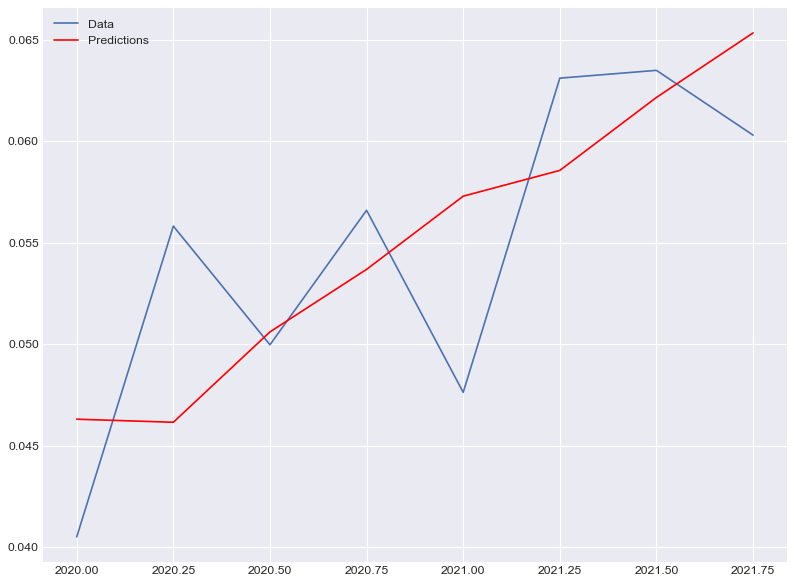

In [3866]:
plotComparison(time_seq['LG'], list(var_pred_full['LG']))

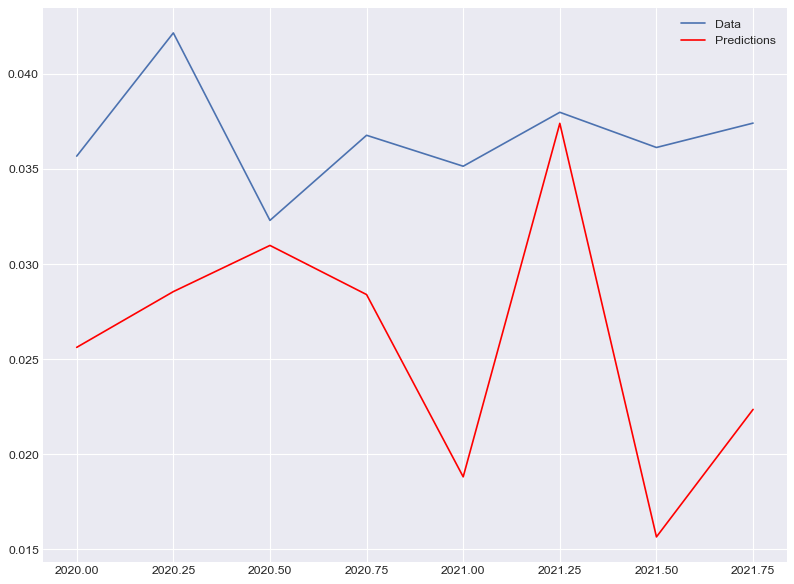

In [3867]:
plotComparison(test['IR'], subject_predictions_list['IR'])

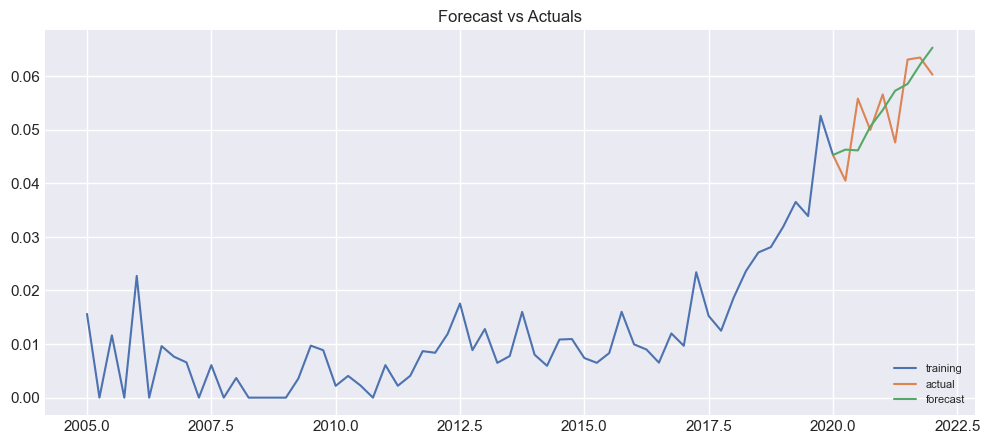

In [3868]:
plotArima(time_seq['LG'][:-8], time_seq['LG'][-8:], var_pred_full['LG'])

Comparison

In [3822]:
def compareRMSE(rmse1, rmse2):
    #rmse1 - original
    #rmse2 - one to compare
    rmse_comparison = {}
    for subj in rmse1.keys():
        rmse_comparison[subj] = rmse2[subj]-rmse1[subj]
    return rmse_comparison

In [3823]:
rmse_var_comp = compareRMSE(rmse_original, rmse_var)
rmse_var_comp

{'CV': -0.0009210584829009716,
 'LG': 0.003255662631396182,
 'CL': 0.005097099023474404,
 'SD': -0.0028181226387282467,
 'AR': -0.009420990781647758,
 'RO': 0.0003881085305657457,
 'IR': -0.006674730171285164,
 'CE': -0.008679207706260433,
 'SE': -0.009091360334161315,
 'HC': 0.0008360996424478838,
 'DC': -0.0022206979396233763,
 'CR': -0.0034406200530678753,
 'AI': -0.00907984762333925,
 'ET': -0.0025019216298710024,
 'DB': -0.00031429997169279706,
 'CY': 0.0010718617006249091,
 'GT': -0.004087843947884401,
 'NE': 0.0006600172034210844,
 'MA': -0.005271721481109841,
 'PL': -0.013923615604852186,
 'CG': -0.007534692479070246,
 'IT': -0.002757294311618071,
 'DL': -0.0006367711845141092,
 'SI': 0.00027379742001189516,
 'NI': -0.0073911326814898185,
 'MM': -0.0001783342726078812,
 'CC': -0.003719219879481102,
 'DS': -0.0020814202239002252,
 'PF': -0.003955404610136017,
 'LO': -0.003746087623518614,
 'GR': 0.0005727109515434739,
 'FL': -0.018248279309115222,
 'MS': -0.0040072743974451965,


In [3824]:
rmse_var_full_comp = compareRMSE(rmse_original, rmse_var_full)
rmse_var_full_comp

{'CV': -0.0020913447977464507,
 'LG': -0.0013525538651354644,
 'CL': 0.0078364930497105,
 'SD': 0.0022929439045412912,
 'AR': 0.0010498240245516155,
 'RO': 0.0004435602786508966,
 'IR': -0.0029873618034878518,
 'CE': -0.008140961455218386,
 'SE': -0.011688785701533075,
 'HC': 0.0027969820958579196,
 'DC': -0.0027884181876785237,
 'CR': -0.003402748247410241,
 'AI': -0.0022040831521746886,
 'ET': -0.0011403804855562513,
 'DB': -0.0028679295013017666,
 'CY': 0.0003725937902922978,
 'GT': -0.002259139264066413,
 'NE': 0.01086680838700142,
 'MA': -0.006418174649946393,
 'PL': -0.01606325981769422,
 'CG': -0.0026430238064324065,
 'IT': 0.007419147041314465,
 'DL': 0.00025458809134694393,
 'SI': -0.001517419977992286,
 'NI': -0.005493305748357768,
 'MM': 0.004109161849269597,
 'CC': 0.0010743781741425172,
 'DS': 0.0007640049787084845,
 'PF': -0.0031715928837838187,
 'LO': -0.0055101213046600496,
 'GR': 0.005300729904460225,
 'FL': -0.01687359122026199,
 'MS': -0.0017578143878626785,
 'DM': -

In [3825]:
#Full rmse
print(sum(rmse_var_full_comp.values()))
print(sum(i < 0 for i in rmse_var_full_comp.values()))

-0.09681874664260368
24


Method 2 - ARIMA with Ridge Regression and no prior knowledge
Assumes independence

In [3826]:
# Pre-process data to put it in suitable format
def formMatrices(y_p2, time_seq2):
    learningSubjects = {}
    for subj in topTfIdf.keys():
        learningSubjects[subj] = {}
        learningSubjects[subj]['y'] = time_seq2[subj]
        learningSubjects[subj]['X'] = np.zeros((len(y_p2[0]), len(topTfIdf[subj].keys())))
        i = 0
        for topic in topTfIdf[subj].keys():
            learningSubjects[subj]['X'][:,i] = y_p2[topic]
            i+=1
        #learningSubjects[subj]['X'][:,i] = time_seq2[subj][:len(learningSubjects[subj]['X'][:,i-1])]
    return learningSubjects

In [3827]:
# Ridge regression for forming weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, Ridge

def weightsPrediction(learningSubjects):
    #Forcasting
    fitted_weights = {}
    for subj in learningSubjects.keys():
        X = learningSubjects[subj]['X']
        y = learningSubjects[subj]['y']
        # Split data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)  
        
        reg = Ridge().fit(X_train, y_train)
        fitted_weights[subj] = reg.coef_
        y_train_pred = reg.predict(X_train)
        y_train_accuracy = sqrt(mean_squared_error(y_train, y_train_pred))
        if(subj == 'LG'):
            plotComparison(y_train, y_train_pred)

        y_test_pred = reg.predict(X_test)
        y_test_accuracy = sqrt(mean_squared_error(y_test, y_test_pred))

    return fitted_weights

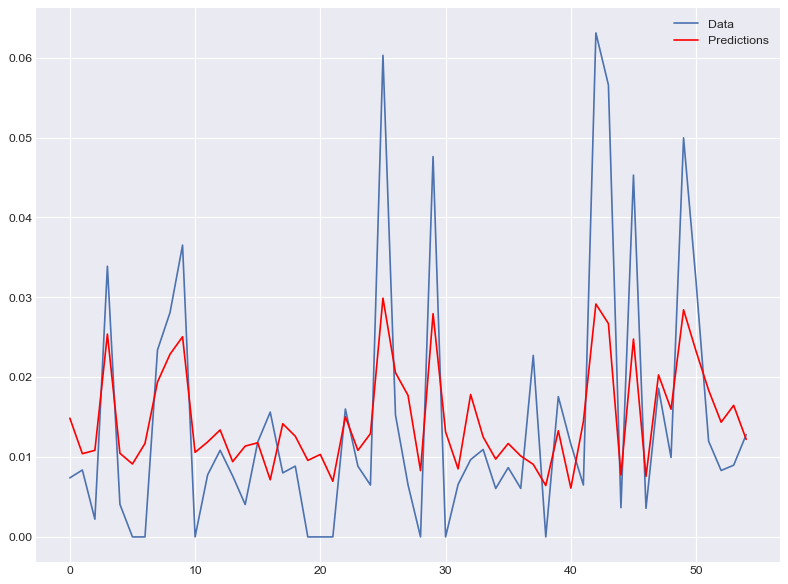

In [3828]:
learningSubjects = formMatrices(y_p, time_seq)
fitted_weights = weightsPrediction(learningSubjects)

In [3829]:
def formFittedWeightsDict(fitted_weights, topTfIdf):
    weights_dict = {}
    for subj in topTfIdf.keys():
        i = 0
        weights_dict[subj] = {}
        for topic in topTfIdf[subj].keys():
            weights_dict[subj][topic] = fitted_weights[subj][i]
            i += 1
    return weights_dict

In [3830]:
weights_dict = formFittedWeightsDict(fitted_weights, topTfIdf)

In [3831]:
def doTopicPredictions(y_p, y2y, time_period, auto):
    #Form an arima seqence for the topics
    topic_predictions = np.zeros((len(y_p),time_period))
    for topic in range(len(y_p)):
        topic_predictions[topic], rmseirr, trainirr, testirr = arima_func(y_p[topic])
    return topic_predictions

In [3832]:
#topic_predictions = doTopicPredictions(y_p, True, 8, True)

In [3833]:
def predict(y_p, time_seq, topic_predictions, weights_dict, time_period):
    total_years = len(y_p[0])

    #Form subject predictions
    subject_seq = {}
    for subject in topTfIdf.keys():
        subject_seq[subject] = np.zeros(time_period)
        for topic in topTfIdf[subject].keys():
            subject_seq[subject] += np.array(topic_predictions[topic])*weights_dict[subject][topic]   
            
    rmse = {}
    index = len(time_seq['AI'])-time_period+1
    for subj in subject_seq.keys():
        rmse[subj] = sqrt(mean_squared_error(time_seq[subj][index:], subject_seq[subj][1:]))

    return subject_seq, rmse

In [3834]:
subject_seq_weighted, rmse_weighted = predict(y_p, time_seq, topic_predictions, weights_dict, 8)

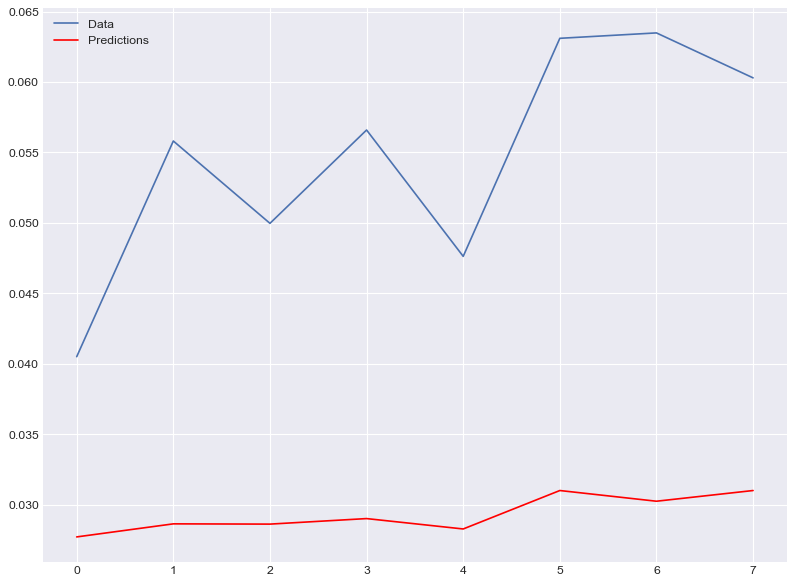

In [3835]:
plotComparison(time_seq['LG'],subject_seq_weighted['LG'])

In [3836]:
rmse_comp_weight = compareRMSE(rmse_original, rmse_weighted)
rmse_comp_weight

{'CV': 0.0028894957565895676,
 'LG': 0.020342172585600407,
 'CL': 0.00956704970874218,
 'SD': 0.0033213080980548683,
 'AR': 0.004910169102903976,
 'RO': 0.015503779486387665,
 'IR': 0.013971396611804658,
 'CE': 0.022200318865694308,
 'SE': 0.008091829396509896,
 'HC': 0.019256290366585053,
 'DC': 0.014698001653756308,
 'CR': 0.026724301383759502,
 'AI': 0.017219122474432316,
 'ET': 0.000338339150664722,
 'DB': 0.0257327493167439,
 'CY': 0.010855133461610378,
 'GT': 0.014012255541086756,
 'NE': 0.02198113514991474,
 'MA': 0.013013678555209686,
 'PL': 0.004485490121459226,
 'CG': 0.007821136472722411,
 'IT': 0.011877284680833879,
 'DL': 0.022319064418842842,
 'SI': 0.0050510788203407125,
 'NI': 0.011855977289338817,
 'MM': 0.009240100449275231,
 'CC': 0.0035551184776700714,
 'DS': 0.009844907785555666,
 'PF': 0.005663669305423955,
 'LO': 0.007977534637727057,
 'GR': 0.007752516196233859,
 'FL': -0.008454200007069467,
 'MS': 0.004402964189938277,
 'DM': 0.00187821614822198,
 'OS': 0.00046

In [3837]:
print(sum(rmse_comp_weight.values()))
print(sum(i < 0 for i in rmse_comp_weight.values()))

0.3724161516810981
4
